In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from tqdm import tqdm 
from torch.nn import init
import random

np.random.seed(21)

/home/abhishek/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Data:
    TABLE_SIZE = 1e8
    def __init__(self,training_data,min_freq,to_be_discard_size):
        self.training_data = training_data
        self.min_freq = min_freq
        self.to_be_discard_size = to_be_discard_size
        self.word2index = {}
        self.index2word = {}
        self.word_freq = {}
        self.sentence_count = 0 
        self.words_count = 0
        self.vocab_size = 0
        self.negatives = []
        self.subSampleTable = []
        self.negativePos = 0
        self.generateWords()
        self.generateNegatives()
        self.generateSubSampleTable()
        

    def generateWords(self):
        temp_dict = {}
        for sentence in self.training_data:
            sentence = sentence.split()
            if len(sentence) < 2:
                continue
            self.sentence_count += 1
            for word in sentence:
                if len(word) < 1:
                    continue
                self.words_count += 1
                if word not in temp_dict:
                    temp_dict[word] = 1
                else:
                    temp_dict[word] += 1
                if self.words_count %(1e6) == 0:
                    print("Processed {} M tokens".format(self.words_count))
        # indexing words for words , start, end and padding
        self.word2index = {'<PAD>':0,'<S>':1,'</S>':2}
        self.index2word = {0:'<PAD>',1:'<S>',2:'</S>'}
        self.word_freq = {'<PAD>':1,'<S>':1,'</S>':1}
        for word,cnt in temp_dict.items():
            # if cnt >= self.min_freq:
            self.word2index[word] = len(self.word2index)
            self.index2word[len(self.index2word)] = word
            self.word_freq[word] = cnt

        self.vocab_size = len(self.word2index)
        print("Vocab size is {}".format(self.vocab_size))
        print("Total number of words {}".format(self.words_count))
        print("Total number of sentences {}".format(self.sentence_count))

    def generateNegatives(self):
        newFreqWords = []
        for word in self.word_freq:
            newFreqWords.append(self.word_freq[word])
        newFreqWords = np.array(newFreqWords)**0.75
        newFreqWords = newFreqWords/np.sum(newFreqWords)
        self.negatives = np.random.choice(len(newFreqWords),size=int(Data.TABLE_SIZE),p=newFreqWords)
        print("Negative samples generated")

    def generateSubSampleTable(self):
        # f = sqrt(t/f) + t/f
        fr = np.array(list(self.word_freq.values()))
        fr = fr/np.sum(fr)
        fr = np.sqrt(1e-3/fr) + 1e-3/fr
        self.subSampleTable = np.round(fr * self.TABLE_SIZE)
        print("Subsample table generated")

    def getNegativeSamples(self,target):
        # initialize the negative position
        negSamples = []
        while len(negSamples) < self.to_be_discard_size:
            neg = self.negatives[self.negativePos]
            self.negativePos = (self.negativePos + 1) % len(self.negatives)
            if neg not in negSamples and neg != target:
                negSamples.append(neg)

        if len(negSamples) != self.to_be_discard_size:
            return np.concatenate((negSamples,self.negatives[:self.to_be_discard_size-len(negSamples)]))
        return negSamples



In [3]:
class Word2vecDataLoader(Dataset):
    def __init__(self, data, windowSize):
        self.data = data
        self.windowSize = windowSize
        self.word2index = data.word2index
        self.index2word = data.index2word
        self.word_freq = data.word_freq
        self.subSampleTable = data.subSampleTable
        self.negatives = data.negatives
        self.length = data.sentence_count

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        sentence = self.data.training_data[idx].split()
        if len(sentence) < 2:
            if idx+1 == self.length:
                idx = 0
            return self.__getitem__(idx+1)
        sentence_ids = [self.word2index[word] for word in sentence if word in self.word2index and np.random.rand() < self.subSampleTable[self.word2index[word]]]
        padded_sent = [self.word2index['<S>']] + sentence_ids + [self.word2index['</S>']]
        cbowData = []
        szOneSide = self.windowSize//2
        for ind,word in enumerate(padded_sent):
            if ind == 0 or ind == len(padded_sent)-1:
                continue
            start = max(0,ind-szOneSide)
            end = min(len(padded_sent)-1,ind+szOneSide)
            context = [padded_sent[i] for i in range(start,end+1) if i != ind]
            if len(context) < 2*(szOneSide):
                context += [self.word2index['<PAD>']]*(2*(szOneSide)-len(context))
            
            cbowData.append((context,word,self.data.getNegativeSamples(word)))

        return cbowData
    
    @staticmethod
    def collate_fn(batches):
        targ_batch = [u for batch in batches for u,v,n in batch if len(batch) > 0]
        context_batch = [v for batch in batches for u,v,n in batch if len(batch) > 0]
        neg_batch = [n for batch in batches for u,v,n in batch if len(batch) > 0]

        return torch.LongTensor(context_batch),torch.LongTensor(targ_batch),torch.LongTensor(neg_batch)
    

class CBOWModule(nn.Module):
    def __init__(self,vocab_size,embedding_size):
        super(CBOWModule,self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.targetEmbedding = nn.Embedding(vocab_size,embedding_size,sparse=True)
        self.contextEmbedding = nn.Embedding(vocab_size,embedding_size,sparse=True)
        initrange = 1.0/self.embedding_size
        init.uniform_(self.targetEmbedding.weight.data,-initrange,initrange)
        init.constant_(self.contextEmbedding.weight.data,0)

    def forward(self,context,target,negatives):
        trg_embedding = self.targetEmbedding(target)
        trg_embedding = torch.mean(trg_embedding,dim=1)
        context_embedding = self.contextEmbedding(context)
        neg_embedding = self.contextEmbedding(negatives)

        positive_score = torch.sum(
            torch.mul(trg_embedding, context_embedding), dim=1)
        positive_score = torch.clamp(positive_score,max=10,min=-10)
        positive_score = -F.logsigmoid(positive_score)

        neg_score = torch.bmm(neg_embedding,torch.unsqueeze(trg_embedding,2)).squeeze()
        neg_score = torch.clamp(neg_score,max=10,min=-10)
        neg_score = -torch.sum(F.logsigmoid(-neg_score),dim=1)

        return torch.mean(positive_score+neg_score)
    
    def embeddingSave(self,ind2word,output_file):
        embedding = self.targetEmbedding.weight.data.cpu().numpy()
        with open(output_file,'w') as f:
            f.write('{} {}\n'.format(len(ind2word),self.embedding_size))
            for word_id,word in ind2word.items():
                tmp = ' '.join(map(lambda x: str(x),embedding[word_id]))
                f.write('{} {}\n'.format(word,tmp))




In [4]:
EMBEDDING_DIM = 300
BATCH_SIZE = 128
WINDOW_SIZE = 11
EPOCHS = 10
LEARNING_RATE = 0.001
NEGATIVE_SAMPLES = 5
MIN_FREQ = 5

In [5]:
class CBOW:
    def __init__(self,training_data,output_file):
        self.data = Data(training_data,min_freq=MIN_FREQ,to_be_discard_size=NEGATIVE_SAMPLES)
        compData = Word2vecDataLoader(self.data,WINDOW_SIZE)
        self.dataloader = DataLoader(compData,batch_size=BATCH_SIZE,shuffle=True,collate_fn=compData.collate_fn)
        self.embedding_size = len(self.data.word2index)
        self.embedding_dim = EMBEDDING_DIM
        self.model = CBOWModule(self.embedding_size, self.embedding_dim)
        self.use_cuda = torch.cuda.is_available()
        self.output_file = output_file
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        if self.use_cuda:
            self.model.cuda()

    def train(self):
        optimizer = optim.SparseAdam(self.model.parameters(),lr=LEARNING_RATE)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,len(self.dataloader),eta_min=0.0001)
        for epoch in range(EPOCHS):
            total_loss = 0.0
            for i,(context,target,negatives) in enumerate(tqdm(self.dataloader)):
                if len(context) == 0:
                    continue
                cont = context.to(self.device)
                targ = target.to(self.device)
                neg = negatives.to(self.device)
                optimizer.step()
                optimizer.zero_grad()
                loss = self.model.forward(cont,targ,neg)
                loss.backward()
                scheduler.step()

                total_loss = total_loss*0.9 + loss.item()*0.1
                if i > 0 and i % 100 == 0:
                    print('Epoch: {} | Batch: {} | Loss: {}'.format(epoch,i,total_loss))
            print('Epoch: {} | Loss: {}'.format(epoch,total_loss))
        self.model.embeddingSave(self.data.index2word,self.output_file)

                

In [6]:
dataLines = []
with open("../../Data/preProcess.txt") as file:
    for line in tqdm(file):
        if line == " ":
            continue
        dataLines.append(line)

print("Number of lines: ", len(dataLines))


200000it [00:00, 587749.11it/s]

Number of lines:  200000


In [7]:
output_file = 'embeddings2.txt'

cbow = CBOW(dataLines[:200000], output_file)
cbow.train()


Processed 1000000 M tokens
Processed 2000000 M tokens
Processed 3000000 M tokens
Processed 4000000 M tokens
Processed 5000000 M tokens
Processed 6000000 M tokens
Processed 7000000 M tokens
Processed 8000000 M tokens
Processed 9000000 M tokens
Processed 10000000 M tokens
Processed 11000000 M tokens
Processed 12000000 M tokens
Processed 13000000 M tokens
Processed 14000000 M tokens
Processed 15000000 M tokens
Processed 16000000 M tokens
Processed 17000000 M tokens
Processed 18000000 M tokens
Processed 19000000 M tokens
Processed 20000000 M tokens
Processed 21000000 M tokens
Processed 22000000 M tokens
Processed 23000000 M tokens
Processed 24000000 M tokens
Vocab size is 3713
Total number of words 24533818
Total number of sentences 199833
Negative samples generated
Subsample table generated


  6%|▋         | 101/1562 [00:31<08:42,  2.80it/s]

Epoch: 0 | Batch: 100 | Loss: 2.5681580822994783


 13%|█▎        | 201/1562 [01:05<07:08,  3.18it/s]

Epoch: 0 | Batch: 200 | Loss: 2.5363114824965707


 19%|█▉        | 301/1562 [01:40<07:10,  2.93it/s]

Epoch: 0 | Batch: 300 | Loss: 2.5333949989580913


 26%|██▌       | 401/1562 [02:16<06:41,  2.89it/s]

Epoch: 0 | Batch: 400 | Loss: 2.5284764369183934


 32%|███▏      | 501/1562 [02:51<06:38,  2.66it/s]

Epoch: 0 | Batch: 500 | Loss: 2.5166400556178345


 38%|███▊      | 601/1562 [03:26<04:45,  3.36it/s]

Epoch: 0 | Batch: 600 | Loss: 2.4887594592307263


 45%|████▍     | 701/1562 [04:01<05:40,  2.53it/s]

Epoch: 0 | Batch: 700 | Loss: 2.476788762304193


 51%|█████▏    | 801/1562 [04:37<04:32,  2.79it/s]

Epoch: 0 | Batch: 800 | Loss: 2.4658544468034327


 58%|█████▊    | 901/1562 [05:13<03:59,  2.76it/s]

Epoch: 0 | Batch: 900 | Loss: 2.45728350374661


 64%|██████▍   | 1001/1562 [05:51<03:56,  2.37it/s]

Epoch: 0 | Batch: 1000 | Loss: 2.4512716894891504


 70%|███████   | 1101/1562 [06:28<02:50,  2.70it/s]

Epoch: 0 | Batch: 1100 | Loss: 2.4431536081940908


 77%|███████▋  | 1201/1562 [07:03<02:32,  2.37it/s]

Epoch: 0 | Batch: 1200 | Loss: 2.4326264348423305


 83%|████████▎ | 1301/1562 [07:42<01:29,  2.91it/s]

Epoch: 0 | Batch: 1300 | Loss: 2.4317357456398856


 90%|████████▉ | 1401/1562 [08:19<00:54,  2.98it/s]

Epoch: 0 | Batch: 1400 | Loss: 2.4255429790804524


 96%|█████████▌| 1501/1562 [08:57<00:22,  2.67it/s]

Epoch: 0 | Batch: 1500 | Loss: 2.421792641760909


100%|██████████| 1562/1562 [09:20<00:00,  2.79it/s]


Epoch: 0 | Loss: 2.4184316505475265


  6%|▋         | 101/1562 [00:38<08:56,  2.72it/s]

Epoch: 1 | Batch: 100 | Loss: 2.4179521574369542


 13%|█▎        | 201/1562 [01:16<09:14,  2.46it/s]

Epoch: 1 | Batch: 200 | Loss: 2.4114468295257168


 19%|█▉        | 301/1562 [01:53<07:43,  2.72it/s]

Epoch: 1 | Batch: 300 | Loss: 2.4082022615203433


 26%|██▌       | 401/1562 [02:32<06:59,  2.76it/s]

Epoch: 1 | Batch: 400 | Loss: 2.3999610799248785


 32%|███▏      | 501/1562 [03:09<06:29,  2.73it/s]

Epoch: 1 | Batch: 500 | Loss: 2.390690692862344


 38%|███▊      | 601/1562 [03:49<06:35,  2.43it/s]

Epoch: 1 | Batch: 600 | Loss: 2.380195317095538


 45%|████▍     | 701/1562 [04:29<05:44,  2.50it/s]

Epoch: 1 | Batch: 700 | Loss: 2.3585568518664886


 51%|█████▏    | 801/1562 [05:07<04:27,  2.84it/s]

Epoch: 1 | Batch: 800 | Loss: 2.3395326398194136


 58%|█████▊    | 901/1562 [05:46<04:18,  2.56it/s]

Epoch: 1 | Batch: 900 | Loss: 2.317544072014006


 64%|██████▍   | 1001/1562 [06:27<03:15,  2.87it/s]

Epoch: 1 | Batch: 1000 | Loss: 2.2842261325206294


 70%|███████   | 1101/1562 [07:07<03:16,  2.35it/s]

Epoch: 1 | Batch: 1100 | Loss: 2.2511583280438736


 77%|███████▋  | 1201/1562 [07:48<02:27,  2.44it/s]

Epoch: 1 | Batch: 1200 | Loss: 2.2168475498856366


 83%|████████▎ | 1301/1562 [08:29<01:57,  2.22it/s]

Epoch: 1 | Batch: 1300 | Loss: 2.1824307652629416


 90%|████████▉ | 1401/1562 [09:11<00:55,  2.92it/s]

Epoch: 1 | Batch: 1400 | Loss: 2.146139124967402


 96%|█████████▌| 1501/1562 [09:52<00:20,  2.97it/s]

Epoch: 1 | Batch: 1500 | Loss: 2.127725748557887


100%|██████████| 1562/1562 [10:16<00:00,  2.53it/s]


Epoch: 1 | Loss: 2.1081590489284037


  6%|▋         | 101/1562 [00:42<09:49,  2.48it/s]

Epoch: 2 | Batch: 100 | Loss: 2.09169430188013


 13%|█▎        | 201/1562 [01:24<10:48,  2.10it/s]

Epoch: 2 | Batch: 200 | Loss: 2.075050863725874


 19%|█▉        | 301/1562 [02:06<09:48,  2.14it/s]

Epoch: 2 | Batch: 300 | Loss: 2.0625585354102887


 26%|██▌       | 401/1562 [02:49<09:38,  2.01it/s]

Epoch: 2 | Batch: 400 | Loss: 2.0471091811947137


 32%|███▏      | 501/1562 [03:31<05:49,  3.03it/s]

Epoch: 2 | Batch: 500 | Loss: 2.0336519760959906


 38%|███▊      | 601/1562 [04:12<06:54,  2.32it/s]

Epoch: 2 | Batch: 600 | Loss: 2.029788450673637


 45%|████▍     | 701/1562 [04:52<06:02,  2.37it/s]

Epoch: 2 | Batch: 700 | Loss: 2.019902545063779


 51%|█████▏    | 801/1562 [05:36<05:48,  2.18it/s]

Epoch: 2 | Batch: 800 | Loss: 2.0152040206179715


 58%|█████▊    | 901/1562 [06:19<04:32,  2.43it/s]

Epoch: 2 | Batch: 900 | Loss: 2.009337063938255


 64%|██████▍   | 1001/1562 [06:59<02:55,  3.20it/s]

Epoch: 2 | Batch: 1000 | Loss: 1.9947743981834503


 70%|███████   | 1101/1562 [07:41<03:35,  2.14it/s]

Epoch: 2 | Batch: 1100 | Loss: 2.005740707366392


 77%|███████▋  | 1201/1562 [08:23<02:25,  2.48it/s]

Epoch: 2 | Batch: 1200 | Loss: 2.001631489525194


 83%|████████▎ | 1301/1562 [09:05<02:02,  2.12it/s]

Epoch: 2 | Batch: 1300 | Loss: 1.9999906343864788


 90%|████████▉ | 1401/1562 [09:48<01:03,  2.53it/s]

Epoch: 2 | Batch: 1400 | Loss: 1.9957433449442026


 96%|█████████▌| 1501/1562 [10:31<00:27,  2.26it/s]

Epoch: 2 | Batch: 1500 | Loss: 1.9926673392926604


100%|██████████| 1562/1562 [10:56<00:00,  2.38it/s]


Epoch: 2 | Loss: 1.9945494375700963


  6%|▋         | 101/1562 [00:42<09:59,  2.44it/s]

Epoch: 3 | Batch: 100 | Loss: 1.989279222644604


 13%|█▎        | 201/1562 [01:27<10:07,  2.24it/s]

Epoch: 3 | Batch: 200 | Loss: 1.9920662951977883


 19%|█▉        | 301/1562 [02:11<08:18,  2.53it/s]

Epoch: 3 | Batch: 300 | Loss: 1.9915221249445032


 26%|██▌       | 401/1562 [02:54<08:27,  2.29it/s]

Epoch: 3 | Batch: 400 | Loss: 1.9911358273593724


 32%|███▏      | 501/1562 [03:37<06:40,  2.65it/s]

Epoch: 3 | Batch: 500 | Loss: 1.9874886948527468


 38%|███▊      | 601/1562 [04:20<07:15,  2.21it/s]

Epoch: 3 | Batch: 600 | Loss: 1.98360143650544


 45%|████▍     | 701/1562 [05:04<05:30,  2.60it/s]

Epoch: 3 | Batch: 700 | Loss: 1.980142865622073


 51%|█████▏    | 801/1562 [05:49<06:32,  1.94it/s]

Epoch: 3 | Batch: 800 | Loss: 1.978108295845719


 58%|█████▊    | 901/1562 [06:31<05:07,  2.15it/s]

Epoch: 3 | Batch: 900 | Loss: 1.9790478850023399


 64%|██████▍   | 1001/1562 [07:15<04:08,  2.25it/s]

Epoch: 3 | Batch: 1000 | Loss: 1.9704437753432715


 70%|███████   | 1101/1562 [07:59<03:04,  2.50it/s]

Epoch: 3 | Batch: 1100 | Loss: 1.9645636597458656


 77%|███████▋  | 1201/1562 [08:42<02:25,  2.47it/s]

Epoch: 3 | Batch: 1200 | Loss: 1.9523980583808176


 83%|████████▎ | 1301/1562 [09:27<01:50,  2.36it/s]

Epoch: 3 | Batch: 1300 | Loss: 1.9493869906054595


 90%|████████▉ | 1401/1562 [10:10<01:04,  2.49it/s]

Epoch: 3 | Batch: 1400 | Loss: 1.9479916980107155


 96%|█████████▌| 1501/1562 [10:54<00:27,  2.25it/s]

Epoch: 3 | Batch: 1500 | Loss: 1.93397016967885


100%|██████████| 1562/1562 [11:23<00:00,  2.29it/s]


Epoch: 3 | Loss: 1.9290846218570437


  6%|▋         | 101/1562 [00:46<13:33,  1.80it/s]

Epoch: 4 | Batch: 100 | Loss: 1.9341357803442307


 13%|█▎        | 201/1562 [01:33<09:03,  2.50it/s]

Epoch: 4 | Batch: 200 | Loss: 1.9251599110676


 19%|█▉        | 301/1562 [02:18<09:48,  2.14it/s]

Epoch: 4 | Batch: 300 | Loss: 1.9212078032193456


 26%|██▌       | 401/1562 [03:04<09:26,  2.05it/s]

Epoch: 4 | Batch: 400 | Loss: 1.914646228248399


 32%|███▏      | 501/1562 [03:49<08:15,  2.14it/s]

Epoch: 4 | Batch: 500 | Loss: 1.9136885474576366


 38%|███▊      | 601/1562 [04:33<07:26,  2.15it/s]

Epoch: 4 | Batch: 600 | Loss: 1.9118071412705124


 45%|████▍     | 701/1562 [05:19<05:50,  2.46it/s]

Epoch: 4 | Batch: 700 | Loss: 1.9023784874132297


 51%|█████▏    | 801/1562 [06:04<05:17,  2.40it/s]

Epoch: 4 | Batch: 800 | Loss: 1.9028044502895942


 58%|█████▊    | 901/1562 [06:48<04:28,  2.46it/s]

Epoch: 4 | Batch: 900 | Loss: 1.9065960360522474


 64%|██████▍   | 1001/1562 [07:29<04:00,  2.34it/s]

Epoch: 4 | Batch: 1000 | Loss: 1.893998927858782


 70%|███████   | 1101/1562 [08:11<03:23,  2.27it/s]

Epoch: 4 | Batch: 1100 | Loss: 1.9022573237369325


 77%|███████▋  | 1201/1562 [08:52<02:18,  2.60it/s]

Epoch: 4 | Batch: 1200 | Loss: 1.9008923593942313


 83%|████████▎ | 1301/1562 [09:33<01:37,  2.67it/s]

Epoch: 4 | Batch: 1300 | Loss: 1.8925634464941858


 90%|████████▉ | 1401/1562 [10:16<01:00,  2.67it/s]

Epoch: 4 | Batch: 1400 | Loss: 1.8951757437765975


 96%|█████████▌| 1501/1562 [10:57<00:23,  2.59it/s]

Epoch: 4 | Batch: 1500 | Loss: 1.8943224567495953


100%|██████████| 1562/1562 [11:22<00:00,  2.29it/s]


Epoch: 4 | Loss: 1.8925433807657348


  6%|▋         | 101/1562 [00:43<10:55,  2.23it/s]

Epoch: 5 | Batch: 100 | Loss: 1.8930878276760301


 13%|█▎        | 201/1562 [01:26<09:42,  2.34it/s]

Epoch: 5 | Batch: 200 | Loss: 1.8929947561615896


 19%|█▉        | 301/1562 [02:08<07:02,  2.99it/s]

Epoch: 5 | Batch: 300 | Loss: 1.8875846960010108


 26%|██▌       | 401/1562 [02:47<07:26,  2.60it/s]

Epoch: 5 | Batch: 400 | Loss: 1.8900882245472168


 32%|███▏      | 501/1562 [03:29<07:22,  2.40it/s]

Epoch: 5 | Batch: 500 | Loss: 1.8858906303000518


 38%|███▊      | 601/1562 [04:11<07:09,  2.24it/s]

Epoch: 5 | Batch: 600 | Loss: 1.894782844994141


 45%|████▍     | 701/1562 [04:54<06:20,  2.26it/s]

Epoch: 5 | Batch: 700 | Loss: 1.8887497320644842


 51%|█████▏    | 801/1562 [05:35<04:56,  2.57it/s]

Epoch: 5 | Batch: 800 | Loss: 1.8861008156115484


 58%|█████▊    | 901/1562 [06:17<04:20,  2.54it/s]

Epoch: 5 | Batch: 900 | Loss: 1.8884006986158242


 64%|██████▍   | 1001/1562 [06:58<03:58,  2.35it/s]

Epoch: 5 | Batch: 1000 | Loss: 1.8873839751677512


 70%|███████   | 1101/1562 [07:39<02:44,  2.81it/s]

Epoch: 5 | Batch: 1100 | Loss: 1.8814100830083873


 77%|███████▋  | 1201/1562 [08:18<02:13,  2.70it/s]

Epoch: 5 | Batch: 1200 | Loss: 1.8732140643998048


 83%|████████▎ | 1301/1562 [09:00<01:30,  2.89it/s]

Epoch: 5 | Batch: 1300 | Loss: 1.8782746401885455


 90%|████████▉ | 1401/1562 [09:41<01:00,  2.65it/s]

Epoch: 5 | Batch: 1400 | Loss: 1.8618795971854836


 96%|█████████▌| 1501/1562 [10:22<00:26,  2.28it/s]

Epoch: 5 | Batch: 1500 | Loss: 1.8705310709468397


100%|██████████| 1562/1562 [10:46<00:00,  2.42it/s]


Epoch: 5 | Loss: 1.870801950439692


  6%|▋         | 101/1562 [00:40<10:08,  2.40it/s]

Epoch: 6 | Batch: 100 | Loss: 1.8686418356514196


 13%|█▎        | 201/1562 [01:20<08:14,  2.75it/s]

Epoch: 6 | Batch: 200 | Loss: 1.8682589632057642


 19%|█▉        | 301/1562 [02:01<07:25,  2.83it/s]

Epoch: 6 | Batch: 300 | Loss: 1.8566679766765084


 26%|██▌       | 401/1562 [02:39<07:22,  2.62it/s]

Epoch: 6 | Batch: 400 | Loss: 1.8580131276903389


 32%|███▏      | 501/1562 [03:19<06:37,  2.67it/s]

Epoch: 6 | Batch: 500 | Loss: 1.8632781384198849


 38%|███▊      | 601/1562 [04:05<06:40,  2.40it/s]

Epoch: 6 | Batch: 600 | Loss: 1.854741453226365


 45%|████▍     | 701/1562 [04:51<07:37,  1.88it/s]

Epoch: 6 | Batch: 700 | Loss: 1.8582920508187288


 51%|█████▏    | 801/1562 [05:34<05:38,  2.25it/s]

Epoch: 6 | Batch: 800 | Loss: 1.8470847091479528


 58%|█████▊    | 901/1562 [06:22<06:28,  1.70it/s]

Epoch: 6 | Batch: 900 | Loss: 1.851614289263103


 64%|██████▍   | 1001/1562 [07:12<04:19,  2.16it/s]

Epoch: 6 | Batch: 1000 | Loss: 1.847333536194648


 70%|███████   | 1101/1562 [08:02<03:25,  2.24it/s]

Epoch: 6 | Batch: 1100 | Loss: 1.8463596057897893


 77%|███████▋  | 1201/1562 [08:52<03:26,  1.75it/s]

Epoch: 6 | Batch: 1200 | Loss: 1.8462050454404604


 83%|████████▎ | 1301/1562 [09:44<01:54,  2.27it/s]

Epoch: 6 | Batch: 1300 | Loss: 1.8418207467443015


 90%|████████▉ | 1401/1562 [10:36<01:30,  1.78it/s]

Epoch: 6 | Batch: 1400 | Loss: 1.8476774727721372


 96%|█████████▌| 1501/1562 [11:27<00:31,  1.91it/s]

Epoch: 6 | Batch: 1500 | Loss: 1.844138126449645


100%|██████████| 1562/1562 [11:59<00:00,  2.17it/s]


Epoch: 6 | Loss: 1.8410849898801194


  6%|▋         | 101/1562 [00:54<15:50,  1.54it/s]

Epoch: 7 | Batch: 100 | Loss: 1.8415556942329723


 13%|█▎        | 201/1562 [01:47<13:32,  1.67it/s]

Epoch: 7 | Batch: 200 | Loss: 1.8374943614573545


 19%|█▉        | 301/1562 [02:43<10:46,  1.95it/s]

Epoch: 7 | Batch: 300 | Loss: 1.8439494951174273


 26%|██▌       | 401/1562 [03:37<12:46,  1.51it/s]

Epoch: 7 | Batch: 400 | Loss: 1.8400303176526807


 32%|███▏      | 501/1562 [04:34<09:58,  1.77it/s]

Epoch: 7 | Batch: 500 | Loss: 1.8469687370609997


 38%|███▊      | 601/1562 [05:29<08:25,  1.90it/s]

Epoch: 7 | Batch: 600 | Loss: 1.841603902804001


 45%|████▍     | 701/1562 [06:23<08:49,  1.63it/s]

Epoch: 7 | Batch: 700 | Loss: 1.8401623920251398


 51%|█████▏    | 801/1562 [07:17<05:55,  2.14it/s]

Epoch: 7 | Batch: 800 | Loss: 1.8329667954445208


 58%|█████▊    | 901/1562 [08:10<05:47,  1.90it/s]

Epoch: 7 | Batch: 900 | Loss: 1.835179891958801


 64%|██████▍   | 1001/1562 [09:04<04:40,  2.00it/s]

Epoch: 7 | Batch: 1000 | Loss: 1.8334241539359646


 70%|███████   | 1101/1562 [09:55<03:32,  2.17it/s]

Epoch: 7 | Batch: 1100 | Loss: 1.837335050262811


 77%|███████▋  | 1201/1562 [10:48<02:46,  2.17it/s]

Epoch: 7 | Batch: 1200 | Loss: 1.8392295815211601


 83%|████████▎ | 1301/1562 [11:39<02:05,  2.08it/s]

Epoch: 7 | Batch: 1300 | Loss: 1.840552557321785


 90%|████████▉ | 1401/1562 [12:32<01:48,  1.49it/s]

Epoch: 7 | Batch: 1400 | Loss: 1.8304178112328455


 96%|█████████▌| 1501/1562 [13:27<00:28,  2.14it/s]

Epoch: 7 | Batch: 1500 | Loss: 1.8344298108618093


100%|██████████| 1562/1562 [13:59<00:00,  1.86it/s]


Epoch: 7 | Loss: 1.834350388412426


  6%|▋         | 101/1562 [00:50<11:39,  2.09it/s]

Epoch: 8 | Batch: 100 | Loss: 1.8278966668623697


 13%|█▎        | 201/1562 [01:40<12:08,  1.87it/s]

Epoch: 8 | Batch: 200 | Loss: 1.8240693501285297


 19%|█▉        | 301/1562 [02:30<09:25,  2.23it/s]

Epoch: 8 | Batch: 300 | Loss: 1.8274624981084726


 26%|██▌       | 401/1562 [03:20<11:28,  1.69it/s]

Epoch: 8 | Batch: 400 | Loss: 1.822640781283551


 32%|███▏      | 501/1562 [04:10<08:02,  2.20it/s]

Epoch: 8 | Batch: 500 | Loss: 1.819680508802405


 38%|███▊      | 601/1562 [05:01<09:23,  1.70it/s]

Epoch: 8 | Batch: 600 | Loss: 1.8202423635279652


 45%|████▍     | 701/1562 [05:54<07:38,  1.88it/s]

Epoch: 8 | Batch: 700 | Loss: 1.8167290138391619


 51%|█████▏    | 801/1562 [06:47<07:24,  1.71it/s]

Epoch: 8 | Batch: 800 | Loss: 1.8227908351703372


 58%|█████▊    | 901/1562 [07:40<06:00,  1.83it/s]

Epoch: 8 | Batch: 900 | Loss: 1.8196781649389735


 64%|██████▍   | 1001/1562 [08:37<05:23,  1.73it/s]

Epoch: 8 | Batch: 1000 | Loss: 1.8167231880085892


 70%|███████   | 1101/1562 [09:30<04:49,  1.59it/s]

Epoch: 8 | Batch: 1100 | Loss: 1.8127866187287875


 77%|███████▋  | 1201/1562 [10:25<03:39,  1.64it/s]

Epoch: 8 | Batch: 1200 | Loss: 1.8136567058598727


 83%|████████▎ | 1301/1562 [11:20<02:34,  1.69it/s]

Epoch: 8 | Batch: 1300 | Loss: 1.8171966165629698


 90%|████████▉ | 1401/1562 [12:14<01:26,  1.86it/s]

Epoch: 8 | Batch: 1400 | Loss: 1.819020269692291


 96%|█████████▌| 1501/1562 [13:11<00:33,  1.84it/s]

Epoch: 8 | Batch: 1500 | Loss: 1.8140336340863696


100%|██████████| 1562/1562 [13:45<00:00,  1.89it/s]


Epoch: 8 | Loss: 1.8089141014270667


  6%|▋         | 101/1562 [00:54<15:08,  1.61it/s]

Epoch: 9 | Batch: 100 | Loss: 1.81989886812952


 13%|█▎        | 201/1562 [01:48<12:30,  1.81it/s]

Epoch: 9 | Batch: 200 | Loss: 1.8129192018744846


 19%|█▉        | 301/1562 [02:40<11:13,  1.87it/s]

Epoch: 9 | Batch: 300 | Loss: 1.8079915954195378


 26%|██▌       | 401/1562 [03:35<10:11,  1.90it/s]

Epoch: 9 | Batch: 400 | Loss: 1.8143407327580767


 32%|███▏      | 501/1562 [04:26<10:45,  1.64it/s]

Epoch: 9 | Batch: 500 | Loss: 1.811611480632041


 38%|███▊      | 601/1562 [05:19<08:59,  1.78it/s]

Epoch: 9 | Batch: 600 | Loss: 1.80950633607125


 45%|████▍     | 701/1562 [06:12<07:52,  1.82it/s]

Epoch: 9 | Batch: 700 | Loss: 1.8118013934236519


 51%|█████▏    | 801/1562 [07:04<05:21,  2.37it/s]

Epoch: 9 | Batch: 800 | Loss: 1.8025674304995787


 58%|█████▊    | 901/1562 [07:56<04:59,  2.21it/s]

Epoch: 9 | Batch: 900 | Loss: 1.8096864812014826


 64%|██████▍   | 1001/1562 [08:49<05:26,  1.72it/s]

Epoch: 9 | Batch: 1000 | Loss: 1.8072824201933013


 70%|███████   | 1101/1562 [09:45<05:20,  1.44it/s]

Epoch: 9 | Batch: 1100 | Loss: 1.8132019710452567


 77%|███████▋  | 1201/1562 [10:42<02:54,  2.07it/s]

Epoch: 9 | Batch: 1200 | Loss: 1.8064704514266445


 83%|████████▎ | 1301/1562 [11:32<02:29,  1.75it/s]

Epoch: 9 | Batch: 1300 | Loss: 1.8118317433783204


 90%|████████▉ | 1401/1562 [12:27<01:22,  1.95it/s]

Epoch: 9 | Batch: 1400 | Loss: 1.804901139772671


 96%|█████████▌| 1501/1562 [13:21<00:32,  1.90it/s]

Epoch: 9 | Batch: 1500 | Loss: 1.8029938865502368


100%|██████████| 1562/1562 [13:54<00:00,  1.87it/s]


Epoch: 9 | Loss: 1.8087478881805235


In [132]:
# save the model
torch.save(cbow.model.state_dict(), 'cbow_model.pt')

In [91]:
import gensim
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import argparse


def colorBars(words, cbow_own,fileName):
    fig, axs = plt.subplots(nrows=len(words), ncols=1,
                            figsize=(20, 2*len(words)))
    color = ['brown', 'red', 'orange', 'yellow',
             'white', 'cyan', 'blue', 'purple', 'black']
    for i, word in enumerate(words):
        vec = cbow_own[word]
        vec = vec/np.linalg.norm(vec)
        axs[i].bar(range(300), vec, color=color)
        axs[i].set_title(word)

    plt.tight_layout()
    plt.savefig(fileName)
    plt.show()

def plot_top10_words(word, cbow_own):

    def tsne_plot(results):
        words = [x[0] for x in results]
        embeds = [x[1] for x in results]
        words = np.array(words)
        embeds = np.array(embeds)
        tsne_model = TSNE(init='pca',perplexity = 19,random_state=42)
        res_embeds = tsne_model.fit_transform(embeds)
        x_axis = res_embeds[:,0]
        y_axis = res_embeds[:,1]
            
        plt.figure(figsize=(10, 10)) 
        for i in range(len(x_axis)):
            plt.scatter(x_axis[i], y_axis[i])
            plt.annotate(words[i], xy=(x_axis[i], y_axis[i]), xytext=(
                5, 2), textcoords='offset points', ha='right', va='bottom')
        # plt.savefig('./Results/'+word+'.png')
    
    if word not in cbow_own:
        print('Word not in vocabulary')
        word = "<UNK>"
    similar_words = cbow_own.most_similar(positive=[word], topn = 10)
    res = {}
    for i, embed in tqdm(enumerate(similar_words)):
        res[embed[0]] = [embed[1], cbow_own[embed[0]]]

    results = []
    scores = 0
    for t in sorted(res.items(), key=lambda item: item[1][0], reverse=True)[0:10]:
        results.append([t[0], t[1][1]])

    print('Word: ', word)
    print('Top 10 similar words: ', [x[0] for x in results])
    print_words = []
    print_words.append(word)
    for i in range(10):
        print_words.append(results[i][0])
    file_name = "./Results/" + word + "_bar.png"
    # colorBars(print_words,cbow_own,file_name)
    # tsne_plot(results)
    return results



cbow_own = gensim.models.KeyedVectors.load_word2vec_format('embeddings.txt', binary=False)


10it [00:00, 36535.75it/s]


Word:  america
Top 10 similar words:  ['japan', 'europe', 'wwii', 'russia', 'wwi', 'england', 'britain', 'germany', 'italy', 'poland']


10it [00:00, 19756.50it/s]


Word:  watch
Top 10 similar words:  ['rewatch', 'revisit', 'cherish', 'see', 'analyze', 'savor', 'relive', 'enjoy', 'stil', 'buy']


10it [00:00, 24300.72it/s]


Word:  they
Top 10 similar words:  ['we', 'themselves', 'thay', 'them', 'voter', 'dinosaur', 'kino', 'these', 'you', 'properly']


10it [00:00, 22465.47it/s]


Word:  well
Top 10 similar words:  ['poorly', 'nicely', 'tastefully', 'beautifully', 'badly', 'professionally', 'wonderfully', 'superbly', 'brilliantly', 'perfectly']


10it [00:00, 23301.69it/s]


Word:  funny
Top 10 similar words:  ['hilarious', 'cute', 'scary', 'freaky', 'smart', 'goofy', 'dumb', 'unintentionally', 'touching', 'comical']


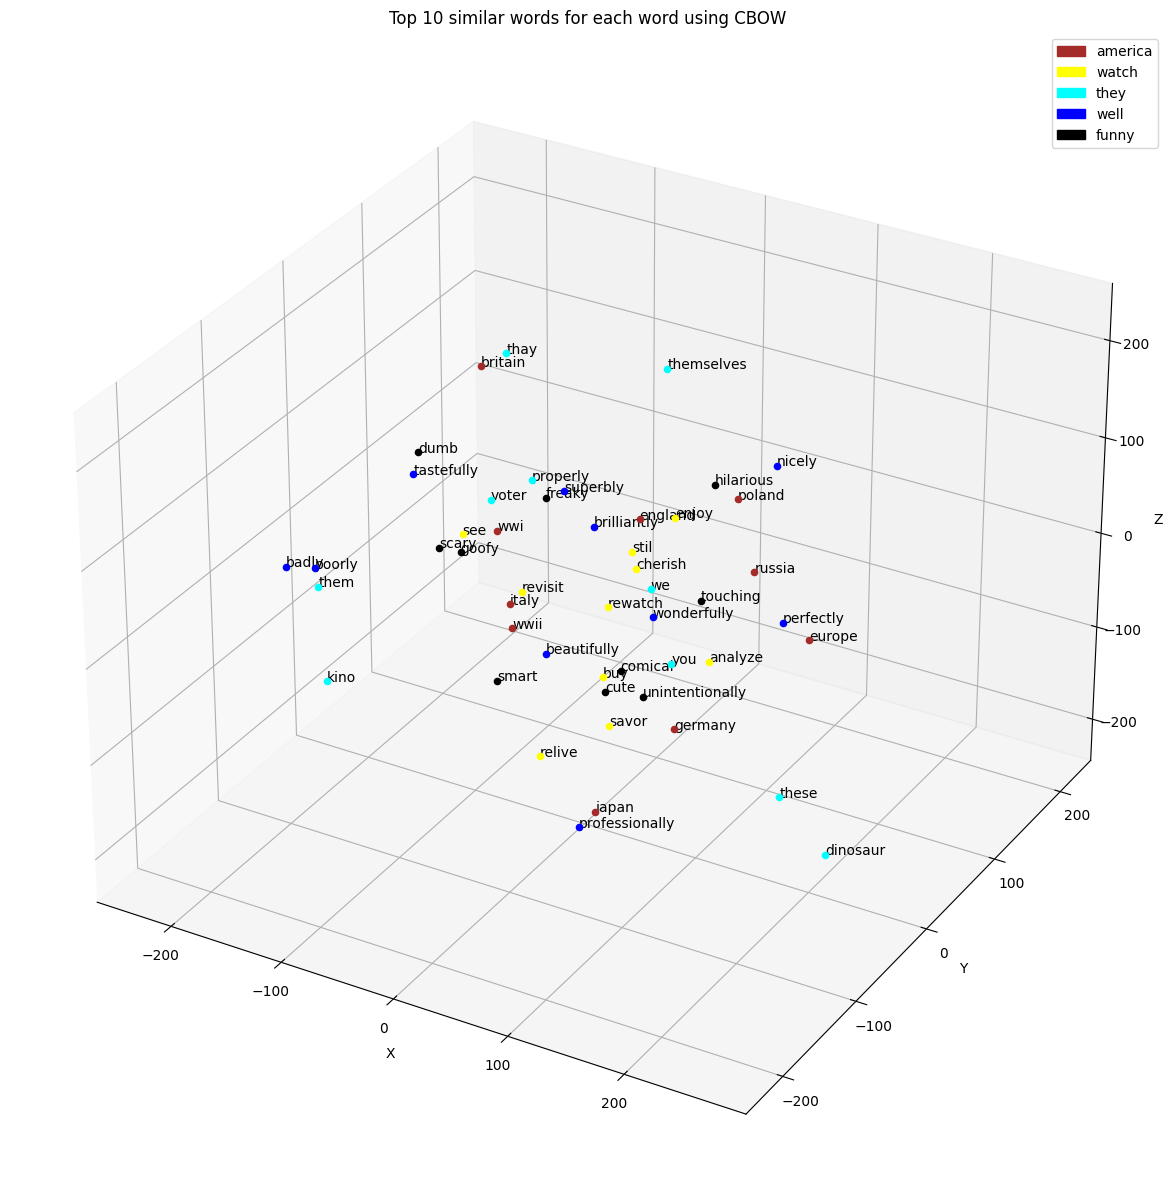

In [131]:

totResults = []
words = ['america', 'watch', 'they', 'well', 'funny']
for word in words:
    totResults.append(plot_top10_words(word, cbow_own))
    # break
#
# plot the top 10 words for each word in words
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
colorsForWord = ['brown', 'yellow', 'cyan', 'blue', 'black']
wordColorDict = dict(zip(words, colorsForWord))
labelForWords = ['america', 'watch', 'they', 'well', 'funny']
# ax.legend(words)
for i, word in enumerate(labelForWords):
    # similiar ressults of one word in one color all in one plot
    # one plot for all words
    words = [x[0] for x in totResults[i]]
    tokens = [x[1] for x in totResults[i]]
    words = np.array(words)
    tokens = np.array(tokens)

    tsne_model = TSNE(n_components=3, init='pca', perplexity=2,
                      metric='cosine', method='exact',random_state=42)
    res_embeds = tsne_model.fit_transform(tokens)

    x_axis = res_embeds[:, 0]
    y_axis = res_embeds[:, 1]
    z_axis = res_embeds[:, 2]

    # print(x_axis)
    # print(y_axis)
    for j in range(len(x_axis)):
        color = wordColorDict[word]
        ax.scatter(x_axis[j], y_axis[j], z_axis[j],color=color)
        ax.text(x_axis[j], y_axis[j], z_axis[j], words[j], size=10, zorder=1, color='k')
# plt.savefig('./Results/' + 'all_words.png')
# legend for color
handles = [plt.Rectangle((0, 0), 1, 1, color=c) for c in colorsForWord]
labels = labelForWords
ax.legend(handles, labels)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.title.set_text('Top 10 similar words for each word using CBOW')


# plt.show()
#legend for word whose color is used



20it [00:00, 123000.12it/s]


Word:  holiday
Top 10 similar words:  ['christmas', 'vacation', 'tradition', 'family', 'weekend', 'halloween', 'eve', 'evening', 'carol', 'afternoon', 'saturday', 'friday', 'season', 'national', 'chevy', 'summer', 'definately', 'sunday', 'morning', 'night']


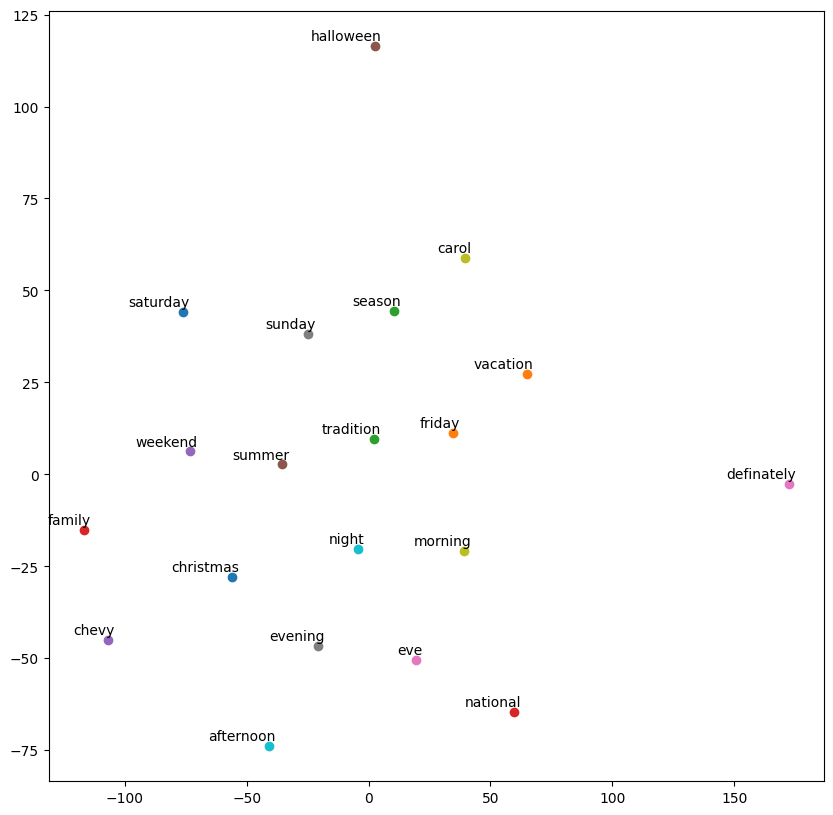

In [23]:
plot_top10_words("holiday", cbow_own)


10it [00:00, 9850.41it/s]


Word:  boat
Top 10 similar words:  ['ship', 'raid', 'highway', 'block', 'wagon', 'patrol', 'pole', 'flag', 'plane', 'subway']


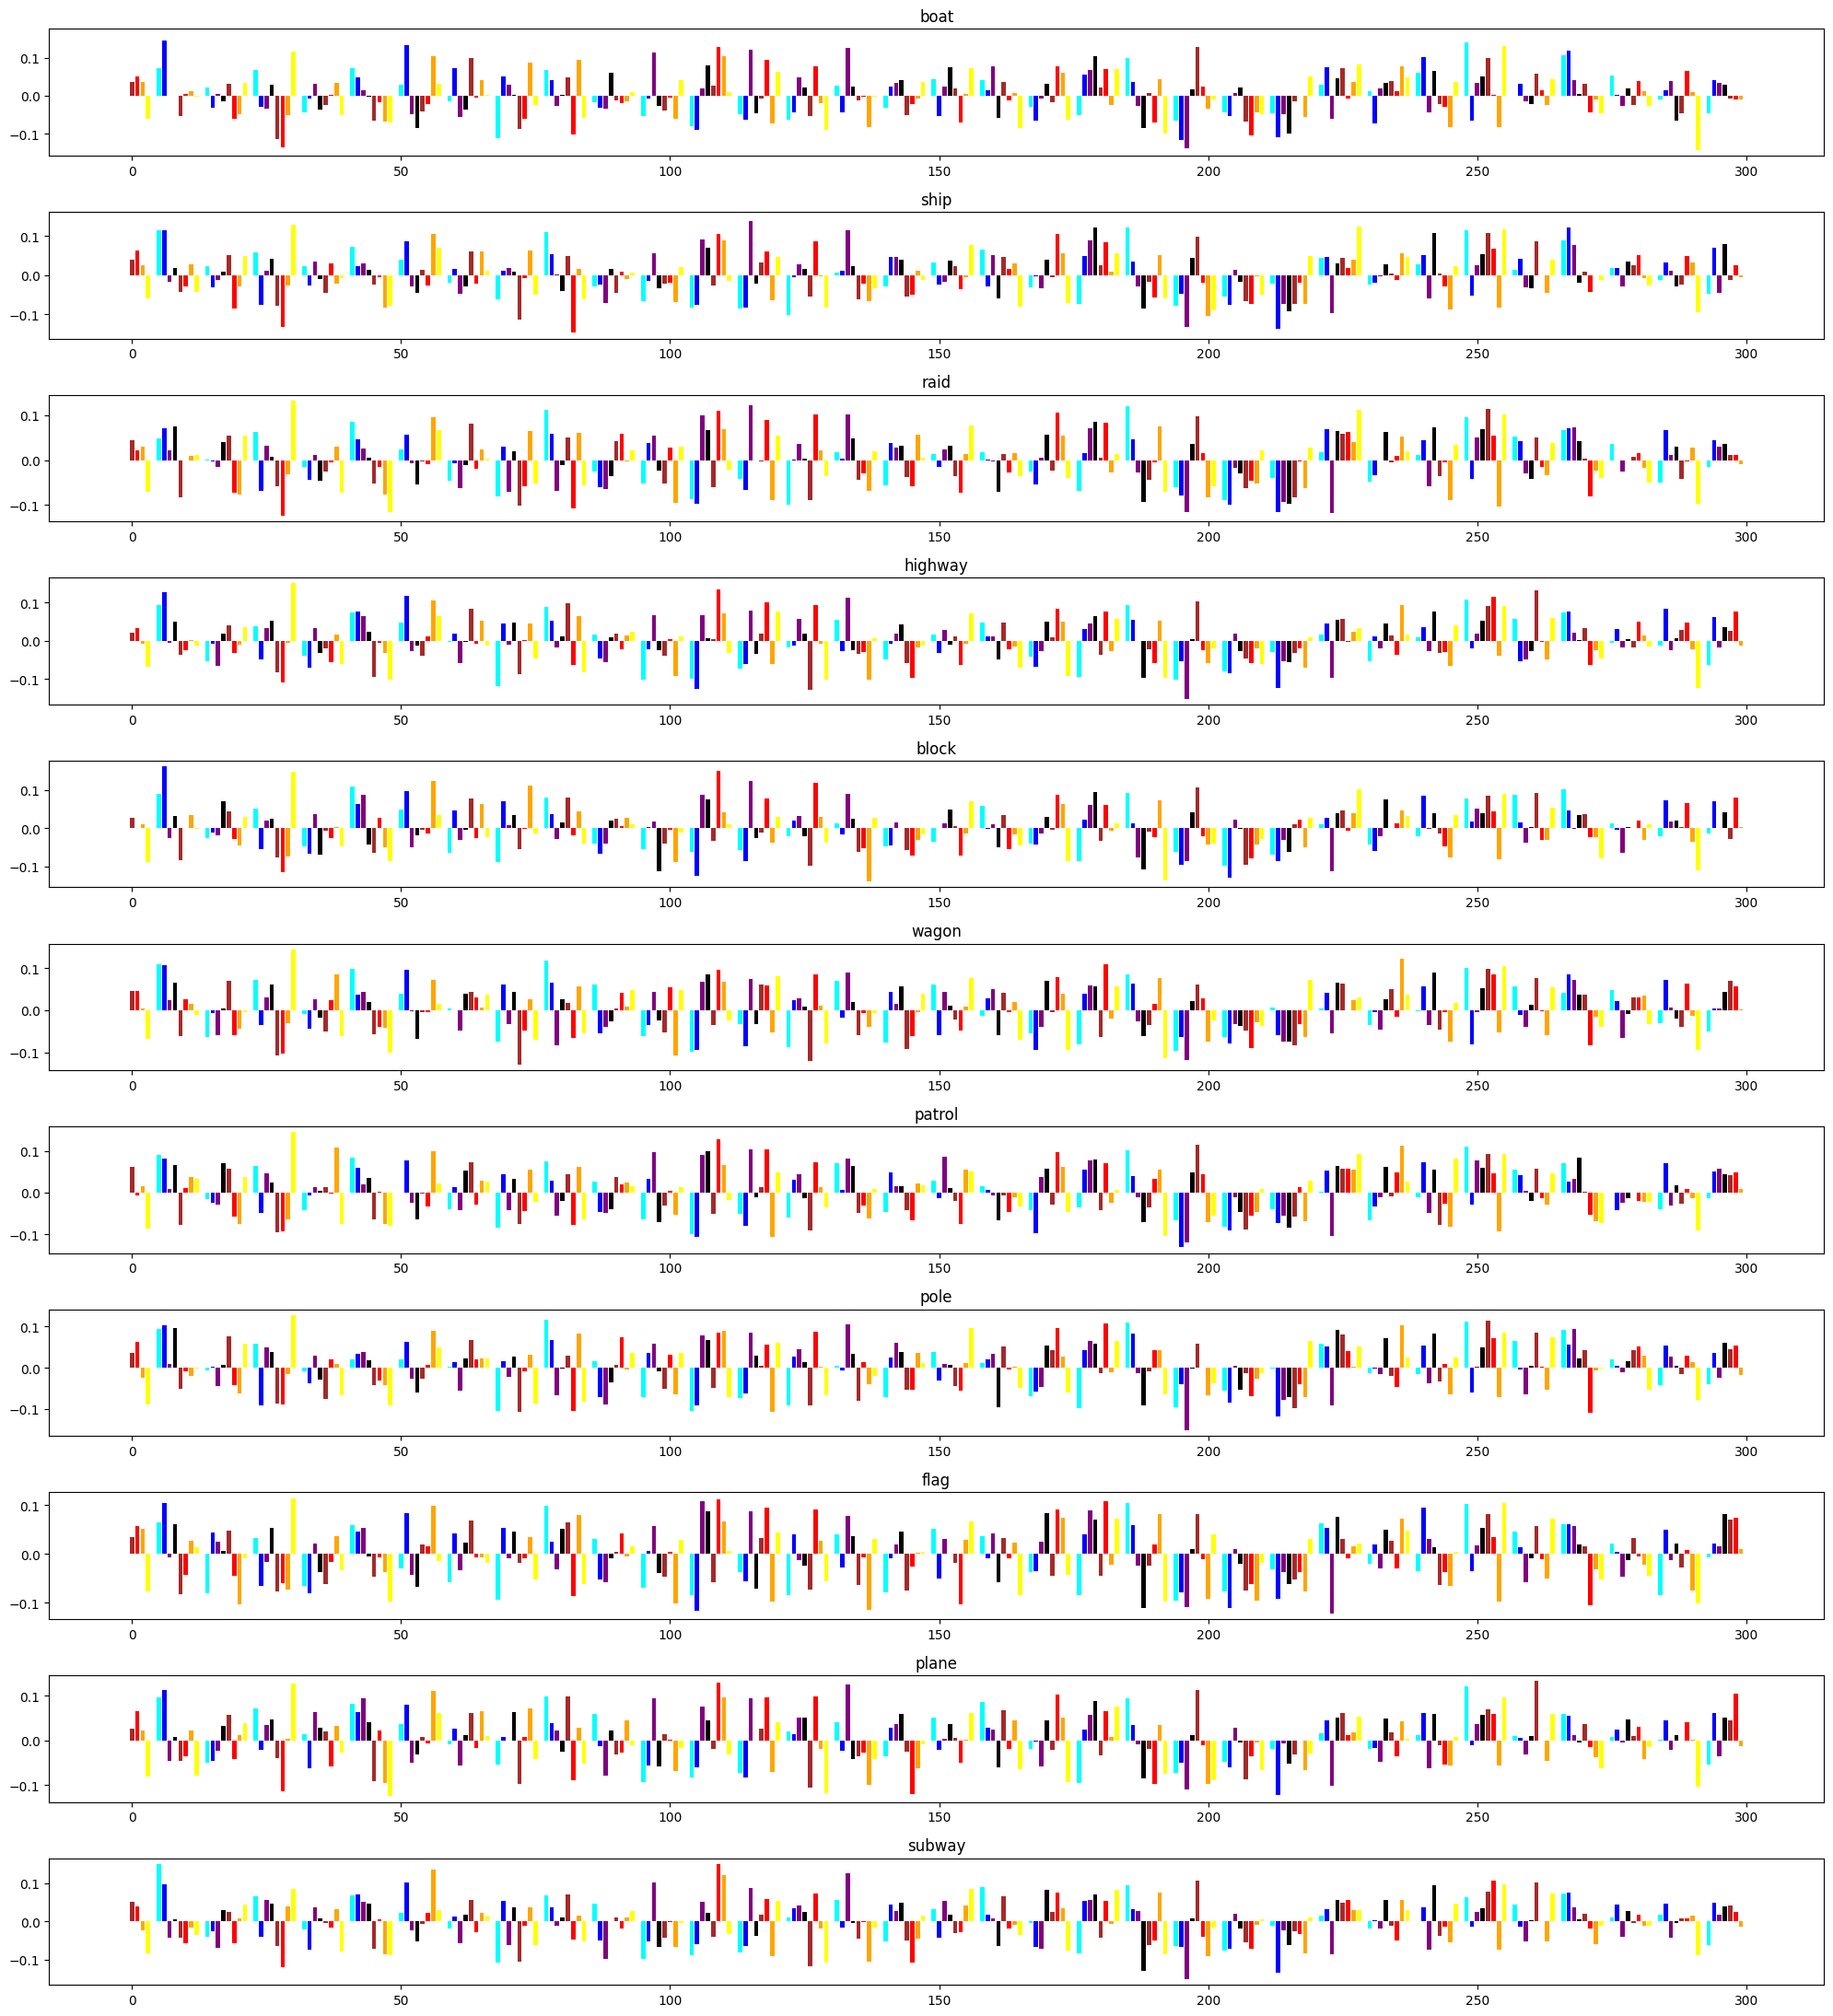

10it [00:00, 65433.76it/s]


Word:  review
Top 10 similar words:  ['reviewer', 'negative', 'description', 'synopsis', 'feedback', 'reveiws', 'editorial', 'title', 'posted', 'criticism']


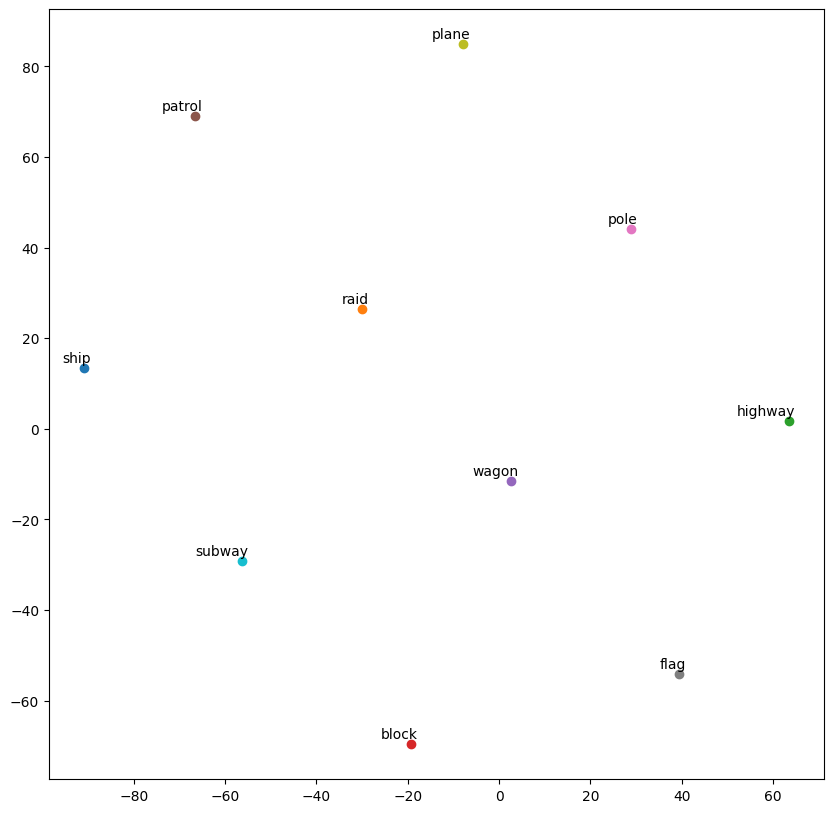

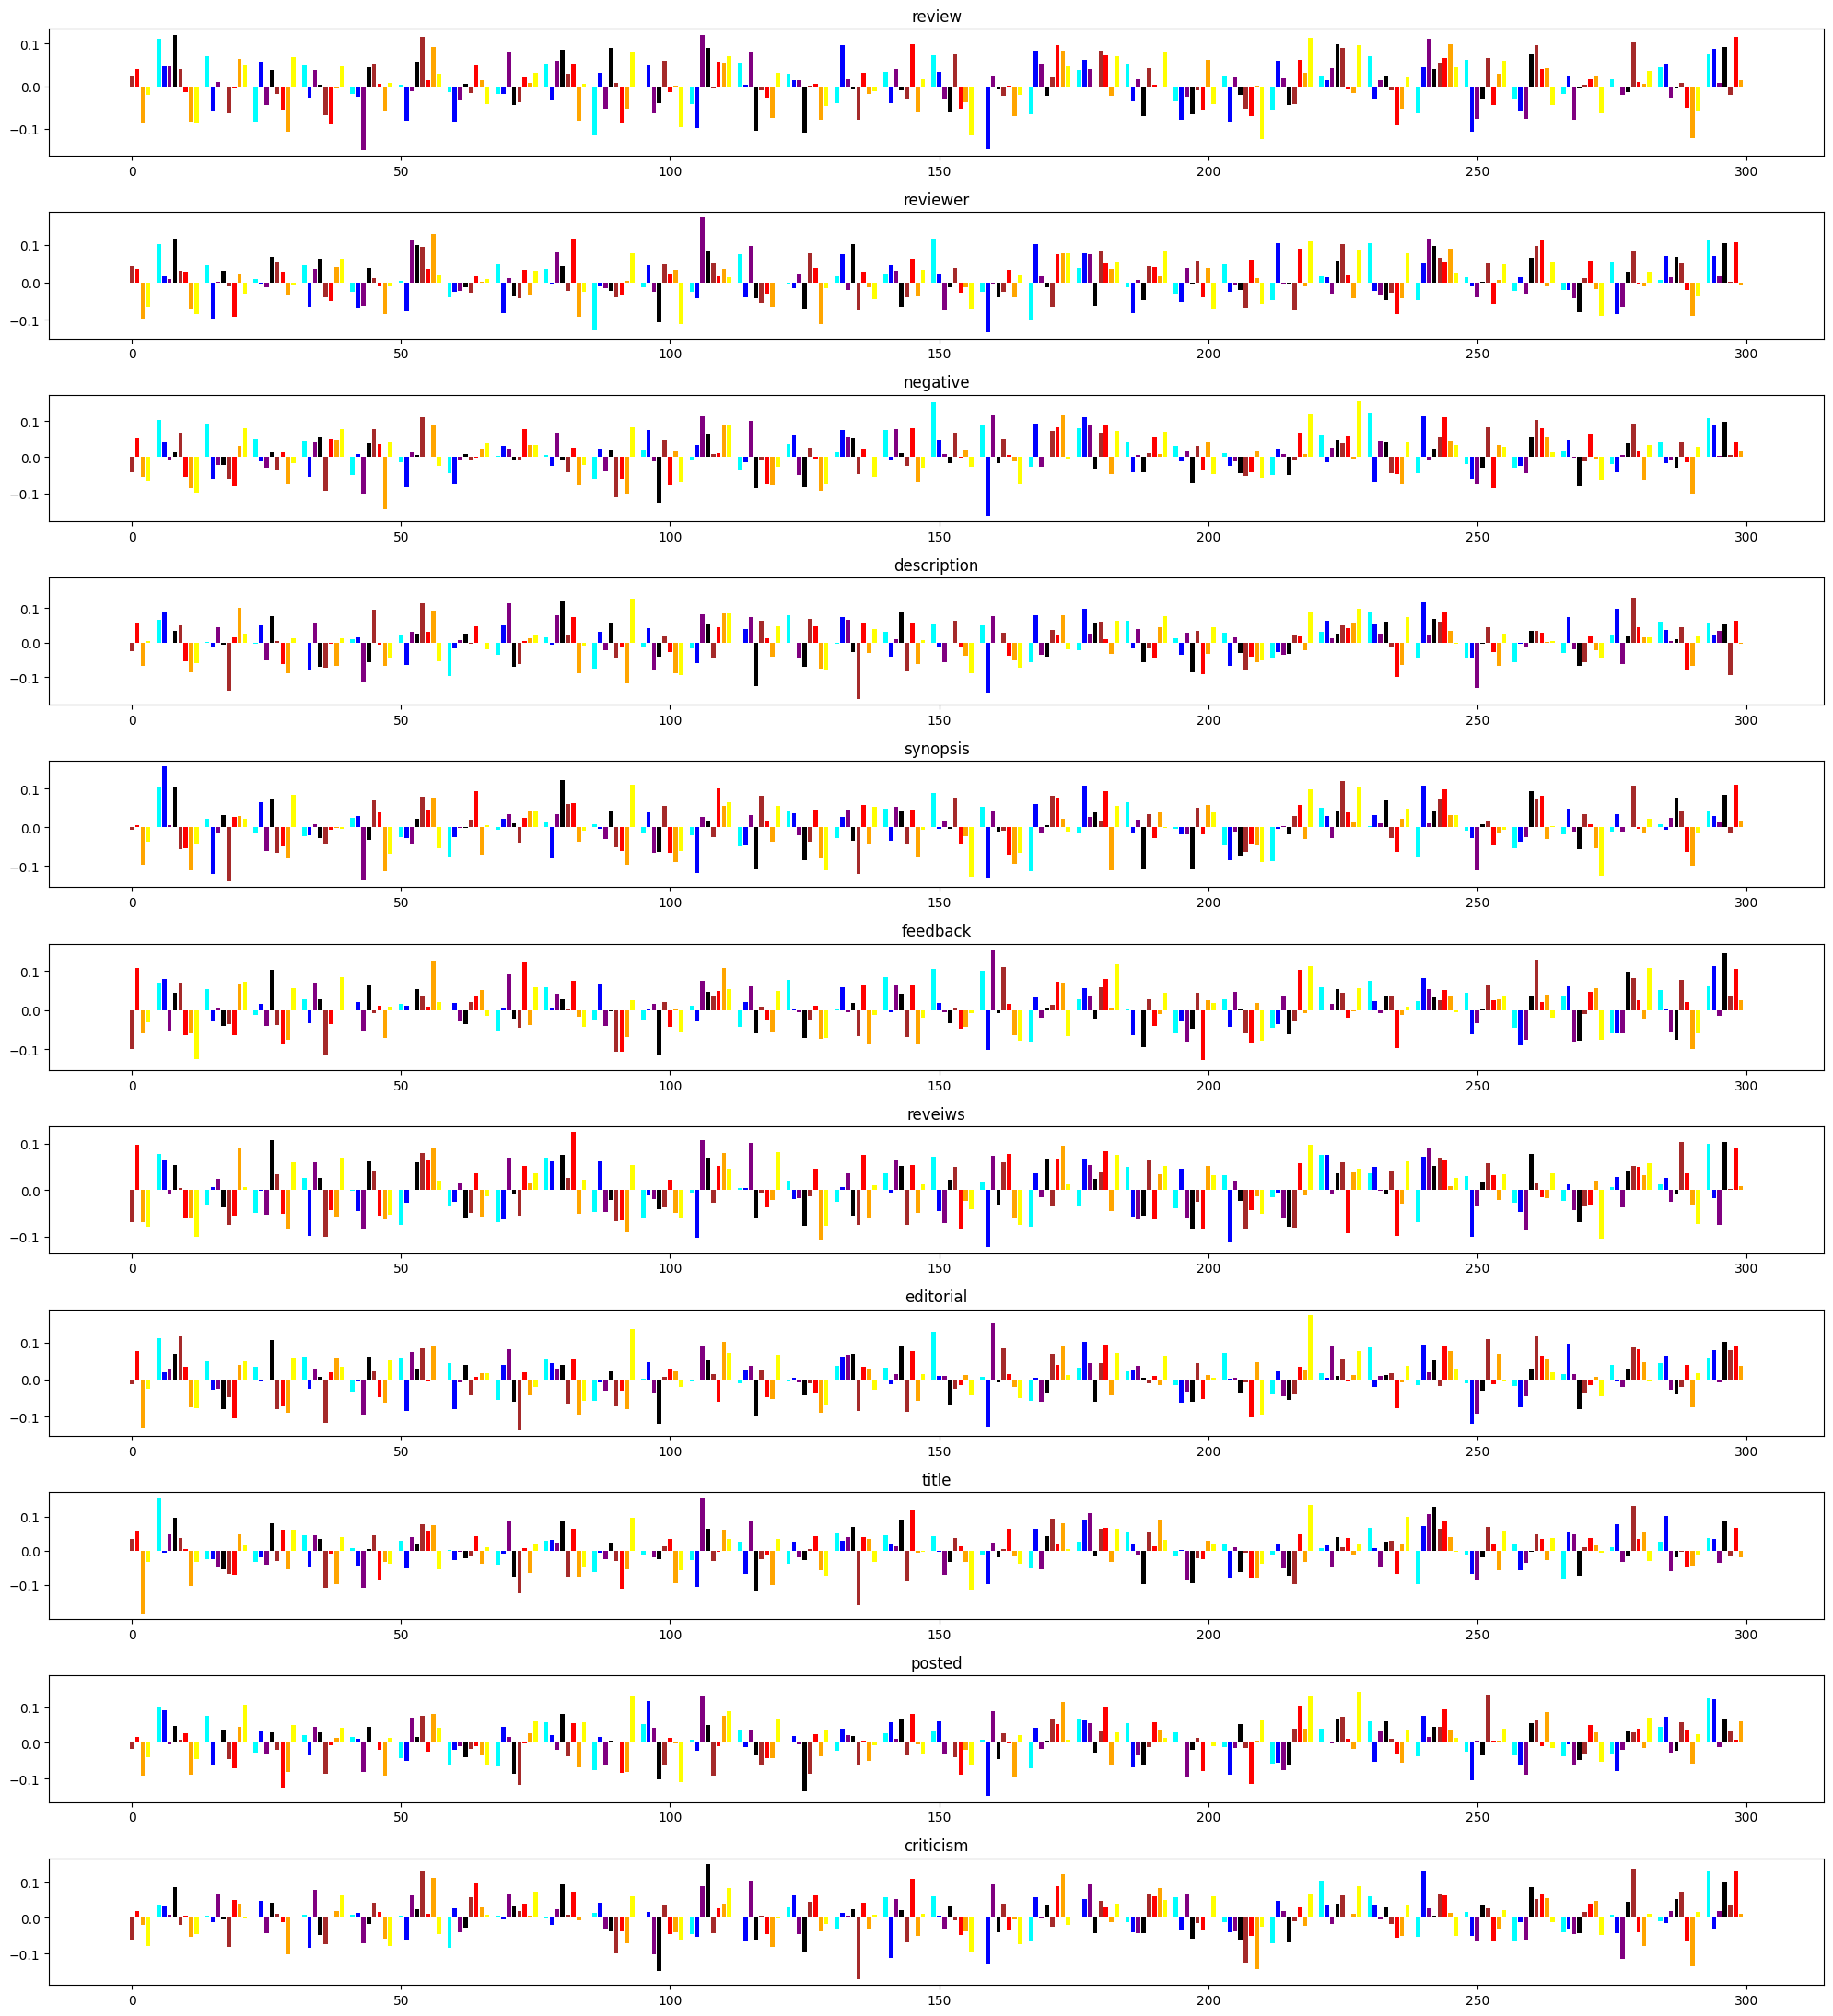

10it [00:00, 92385.55it/s]


Word:  her
Top 10 similar words:  ['herself', 'she', 'mathilda', 'ada', 'ariel', 'karras', 'lydia', 'angela', 'ricky', 'alice']


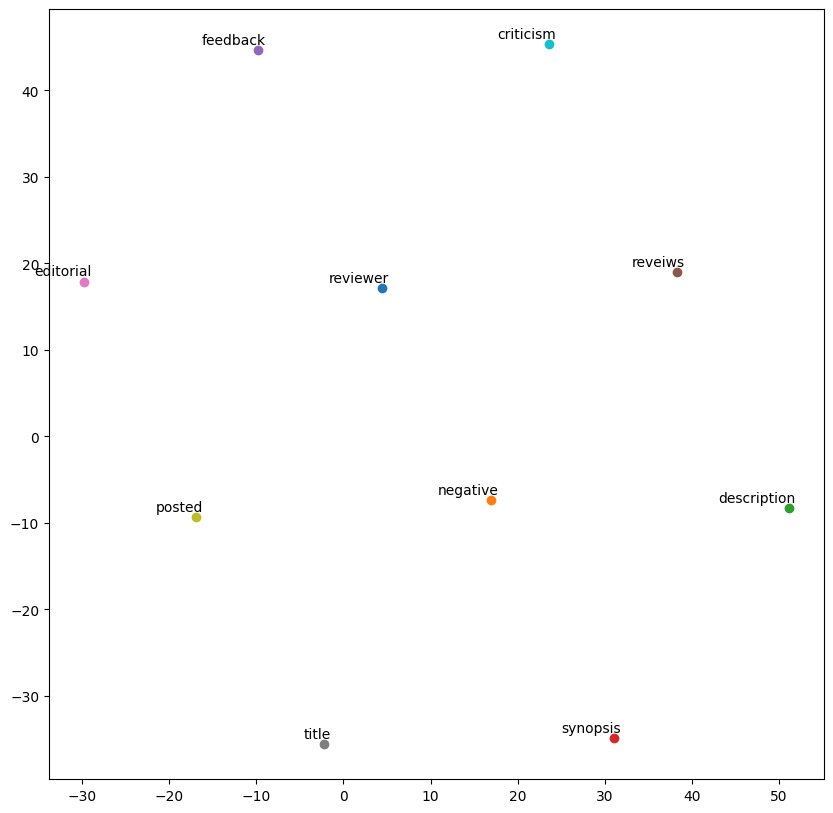

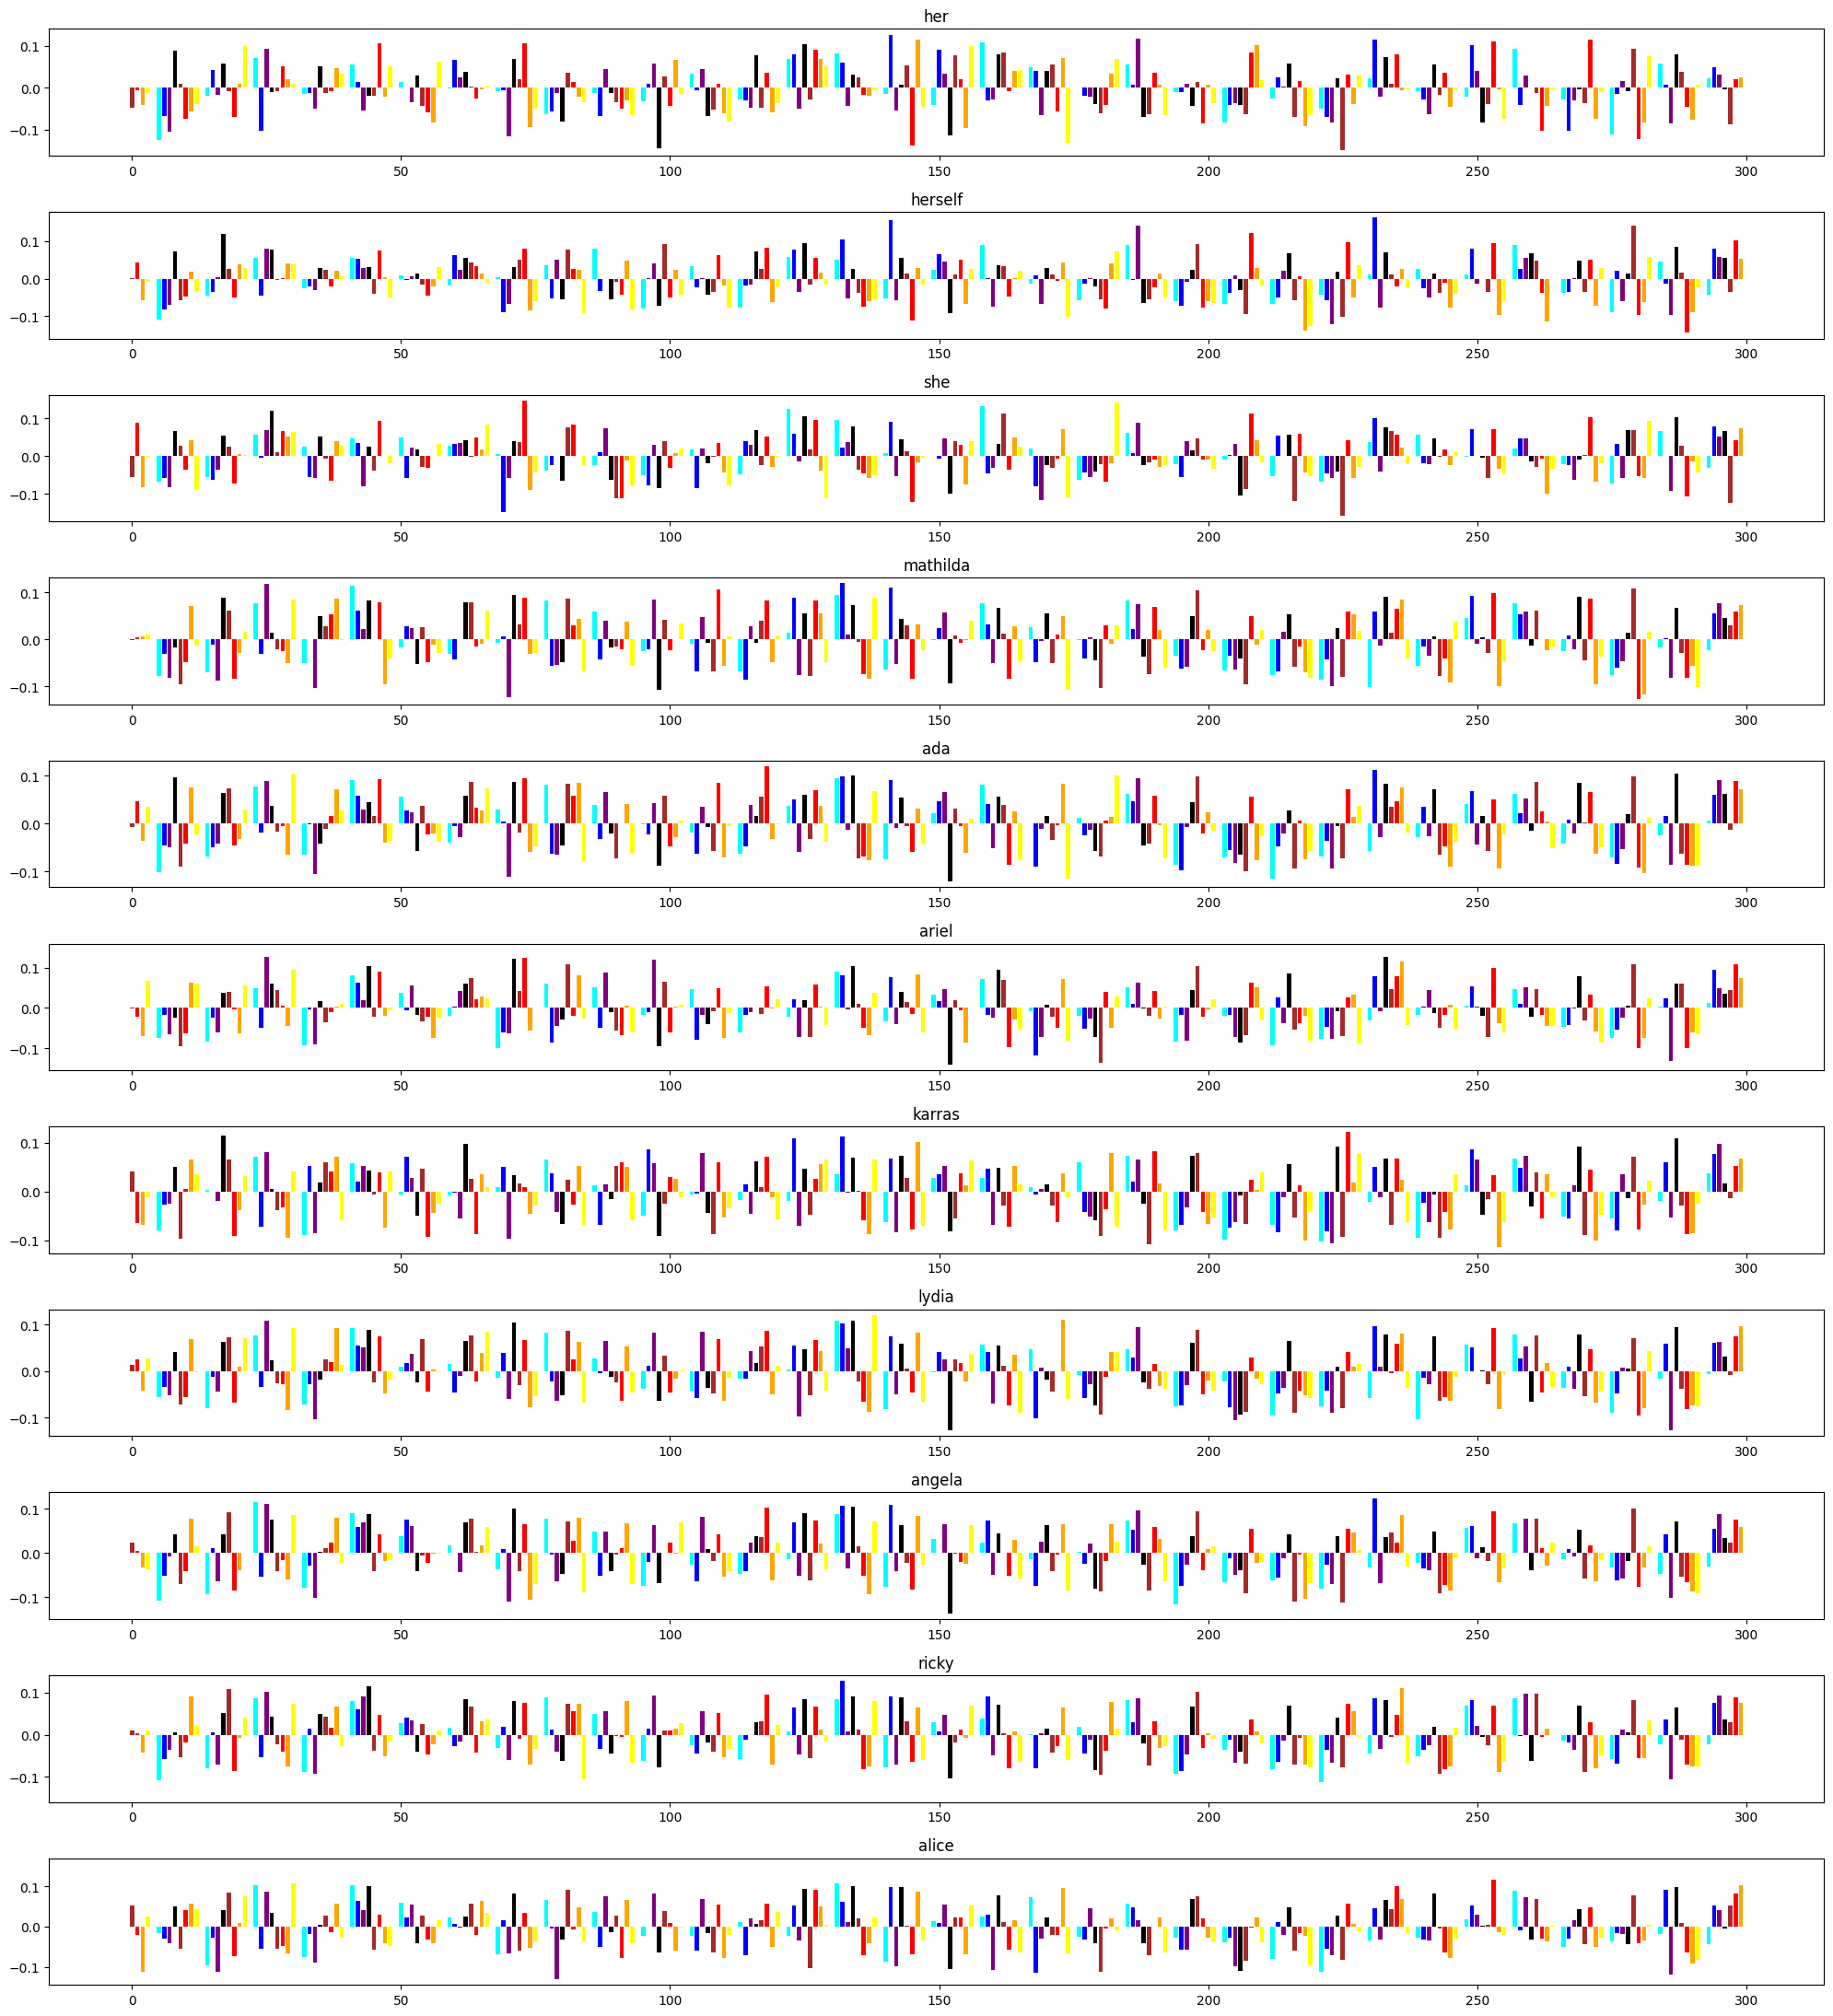

10it [00:00, 62788.98it/s]


Word:  great
Top 10 similar words:  ['fantastic', 'terrific', 'wonderful', 'good', 'fine', 'fabulous', 'superb', 'phenomenal', 'wonderfull', 'marvelous']


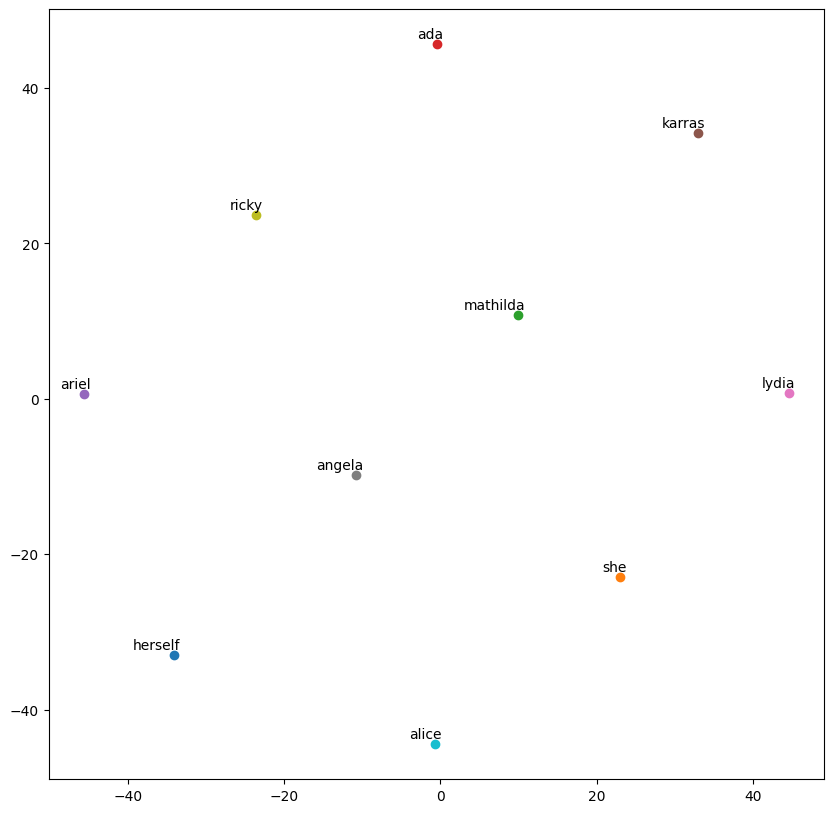

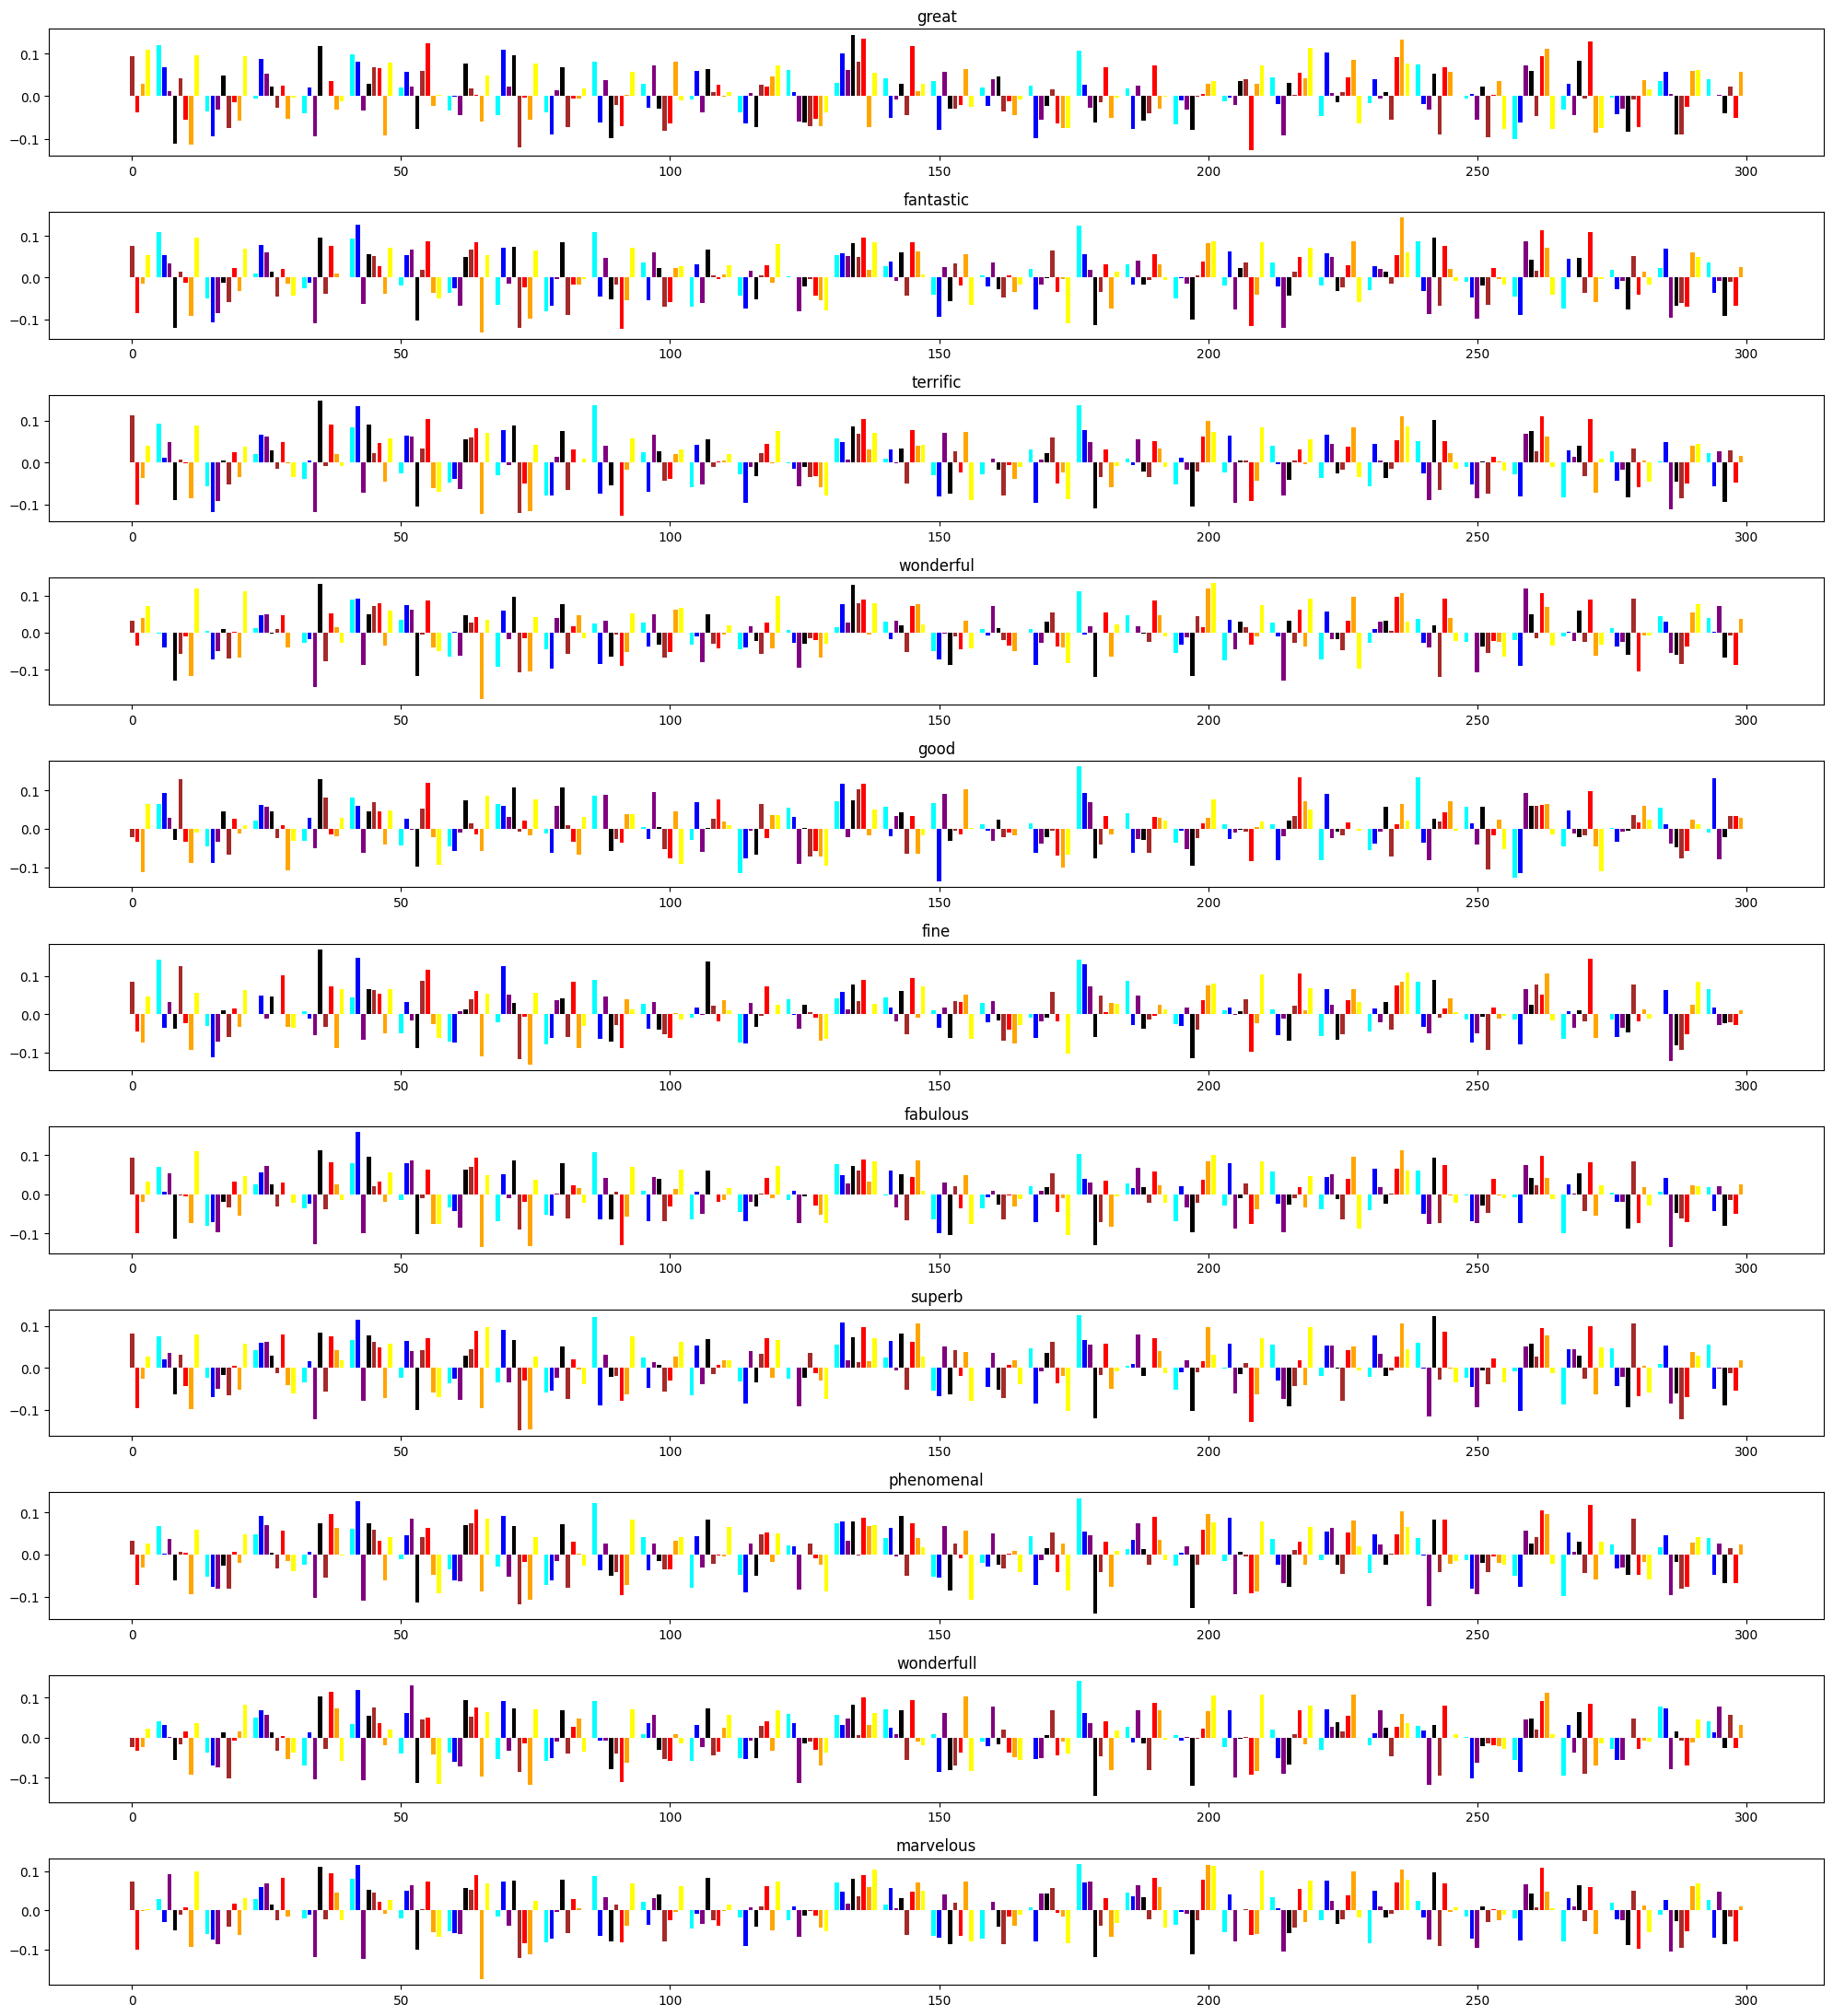

10it [00:00, 19400.11it/s]


Word:  smart
Top 10 similar words:  ['goofy', 'likeable', 'sexy', 'likable', 'cute', 'unfunny', 'wierd', 'tough', 'creepy', 'immature']


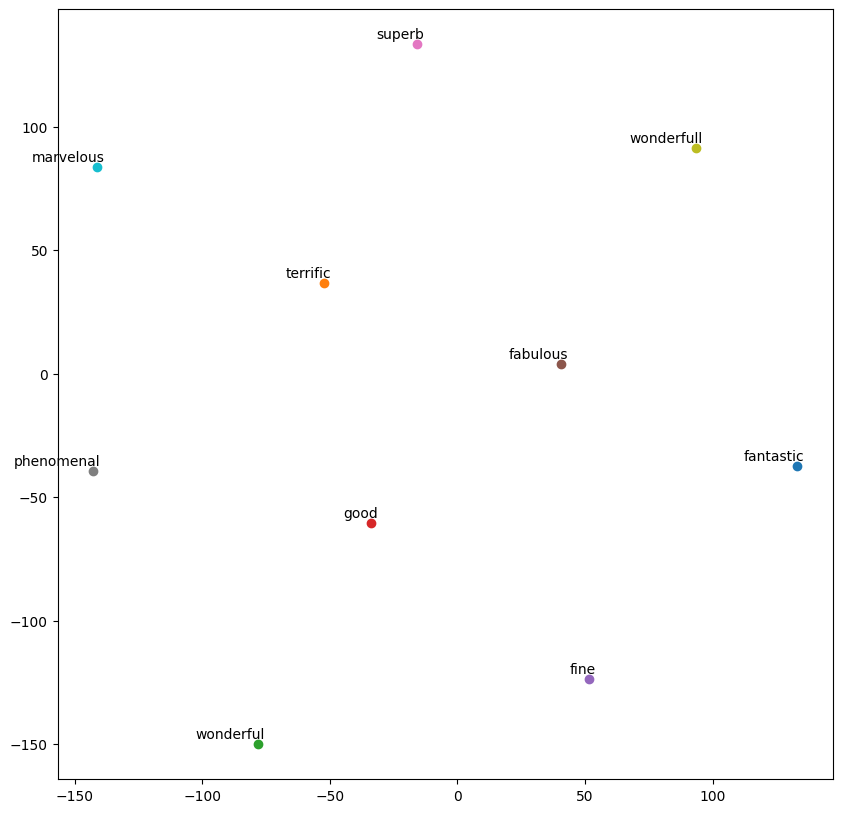

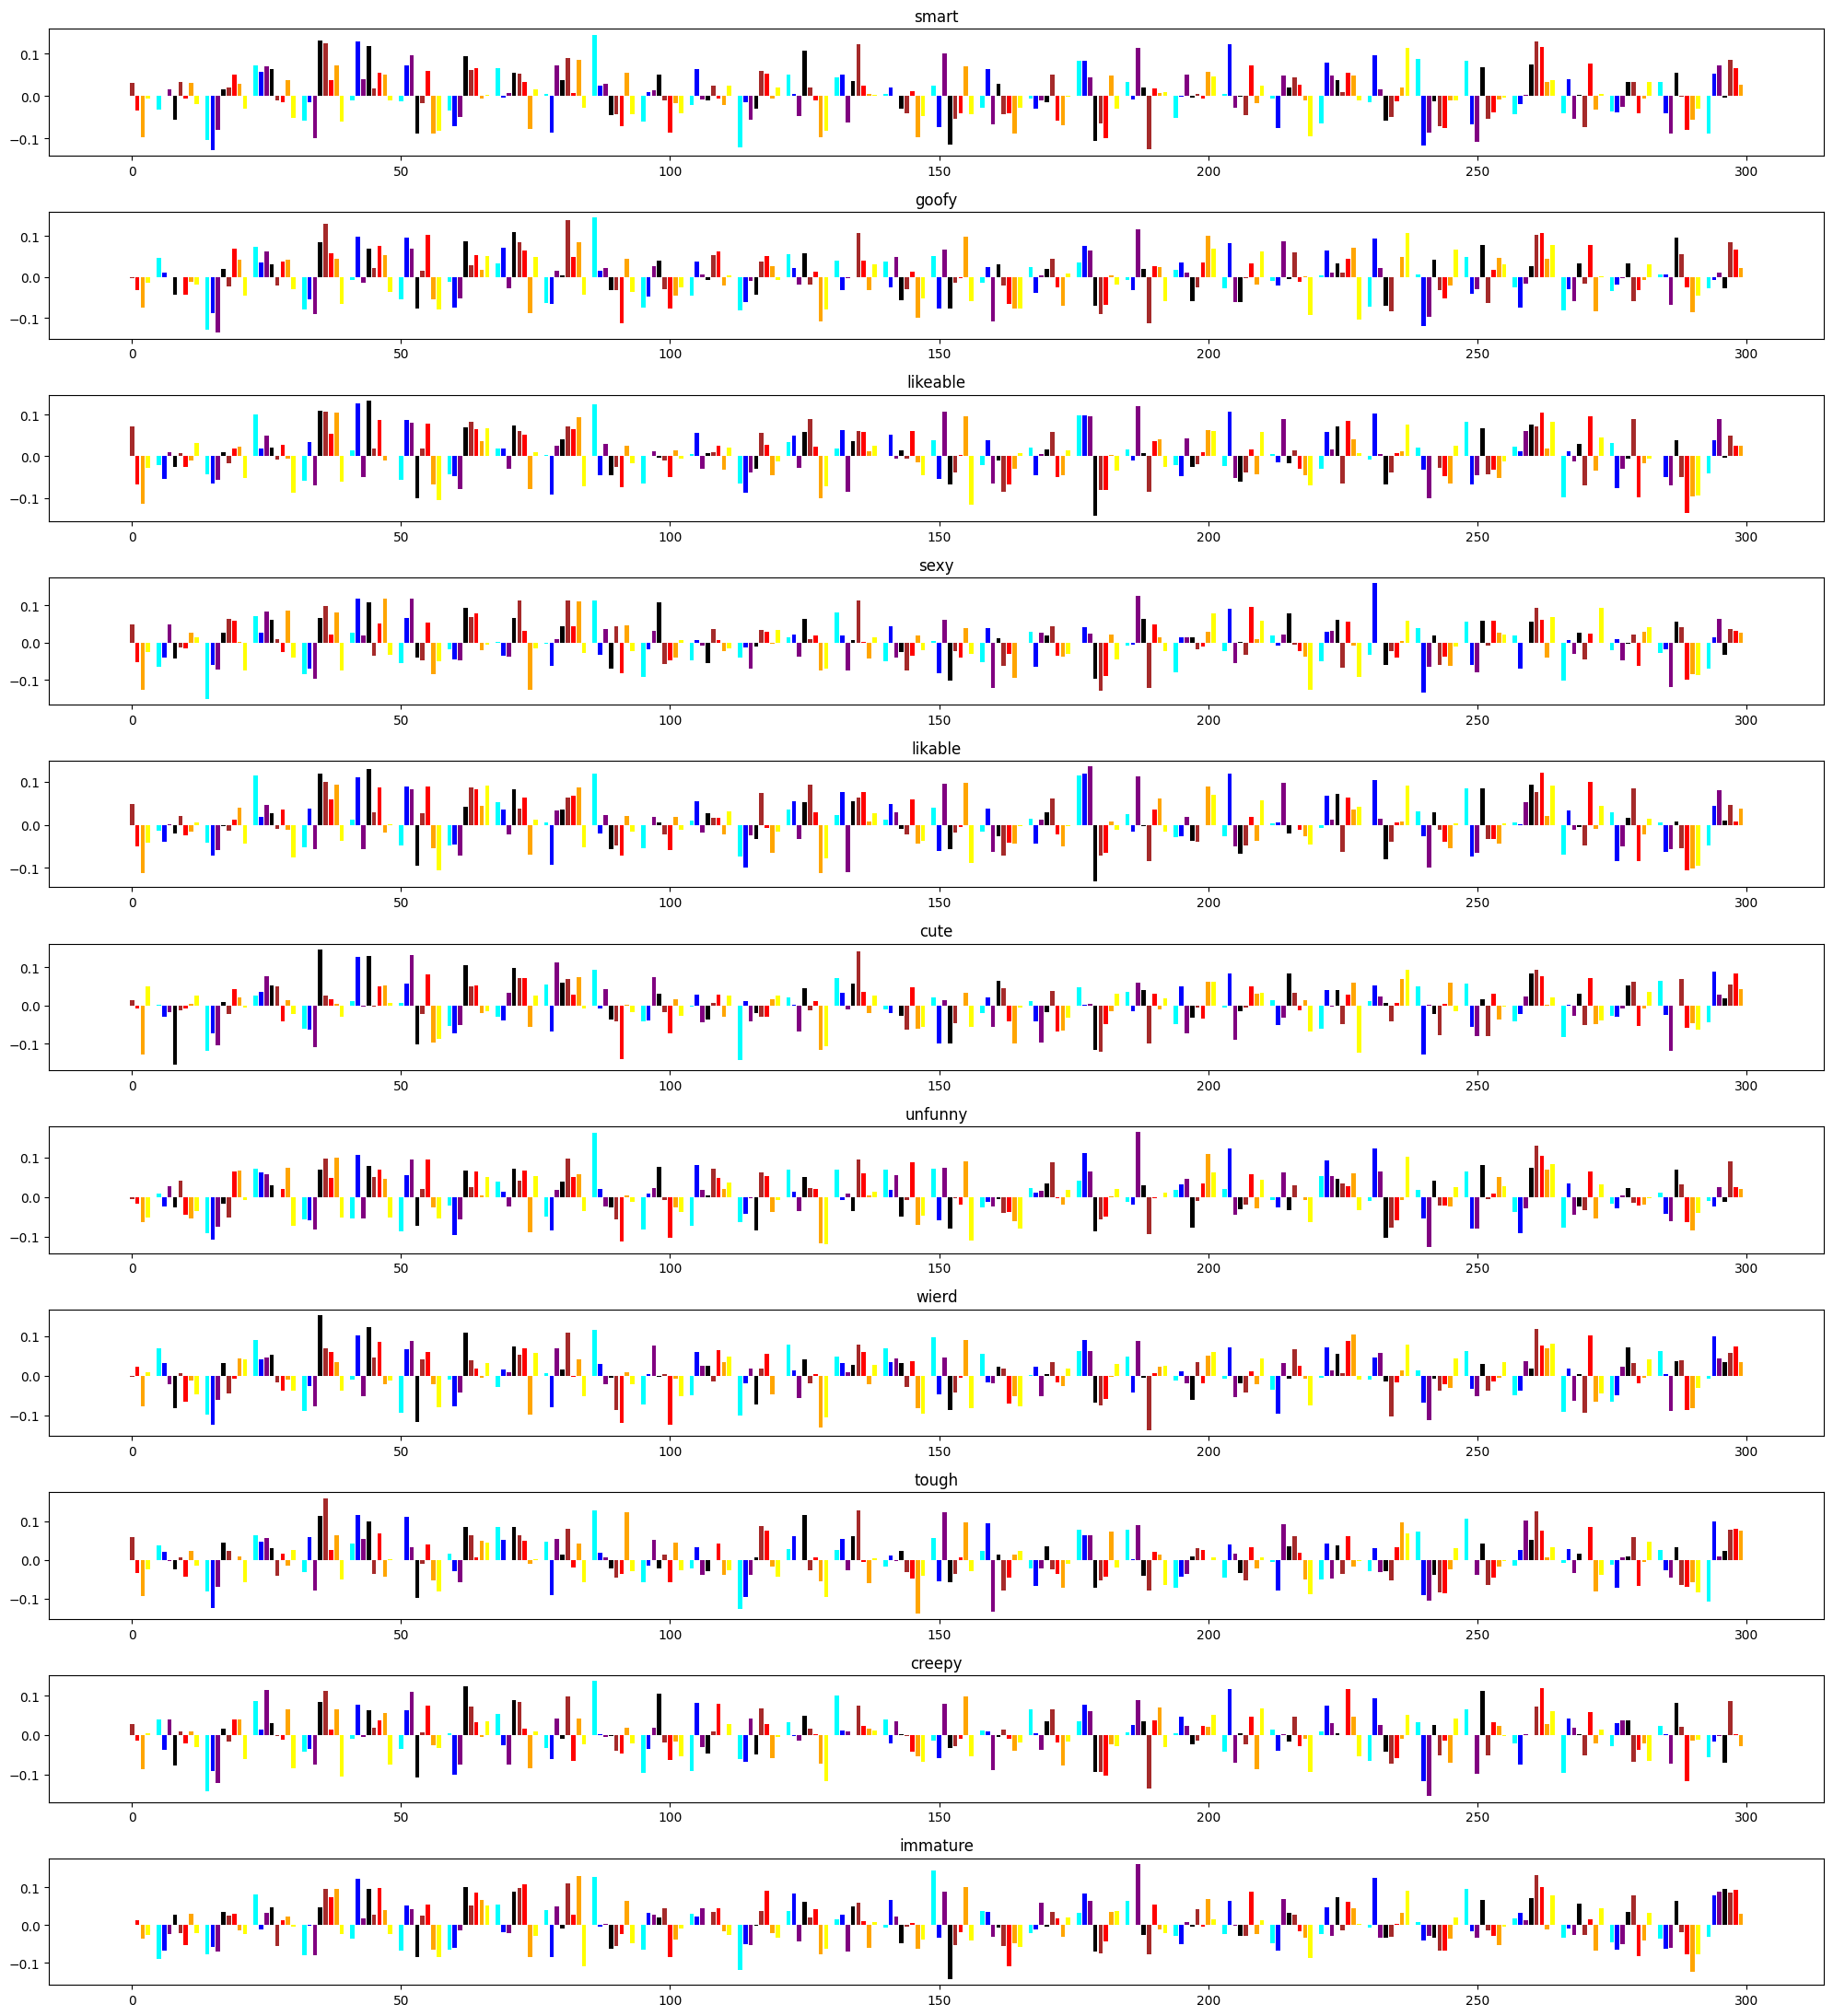

10it [00:00, 87563.76it/s]


Word:  titanic
Top 10 similar words:  ['lotr', '1960', 'robocop', '74', 'talkie', 'ark', 'ninety', 'braveheart', 'phantom', '2000s']


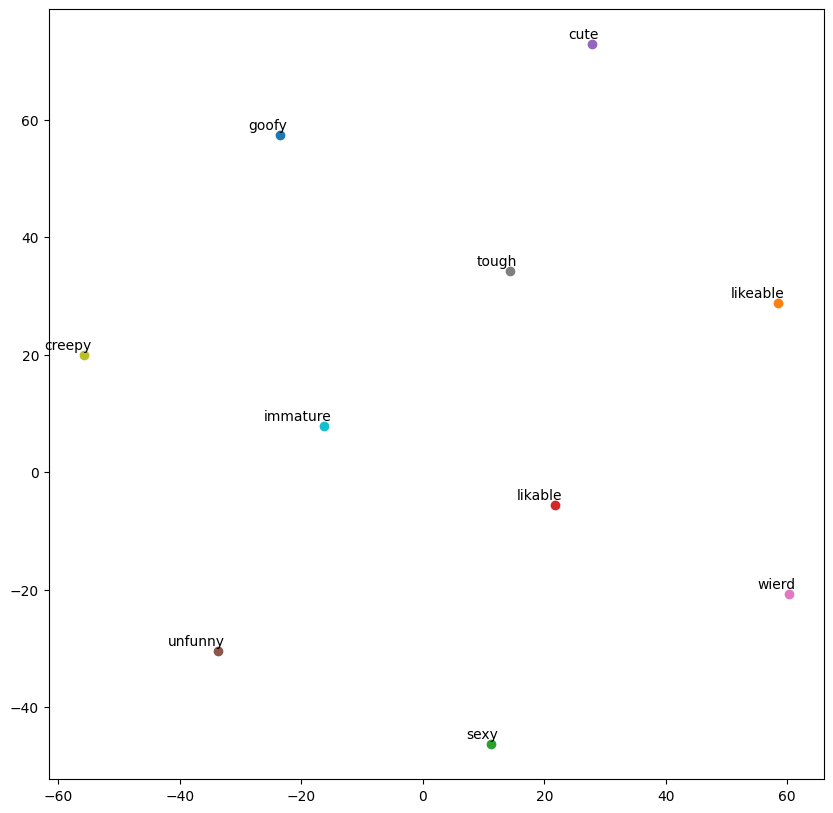

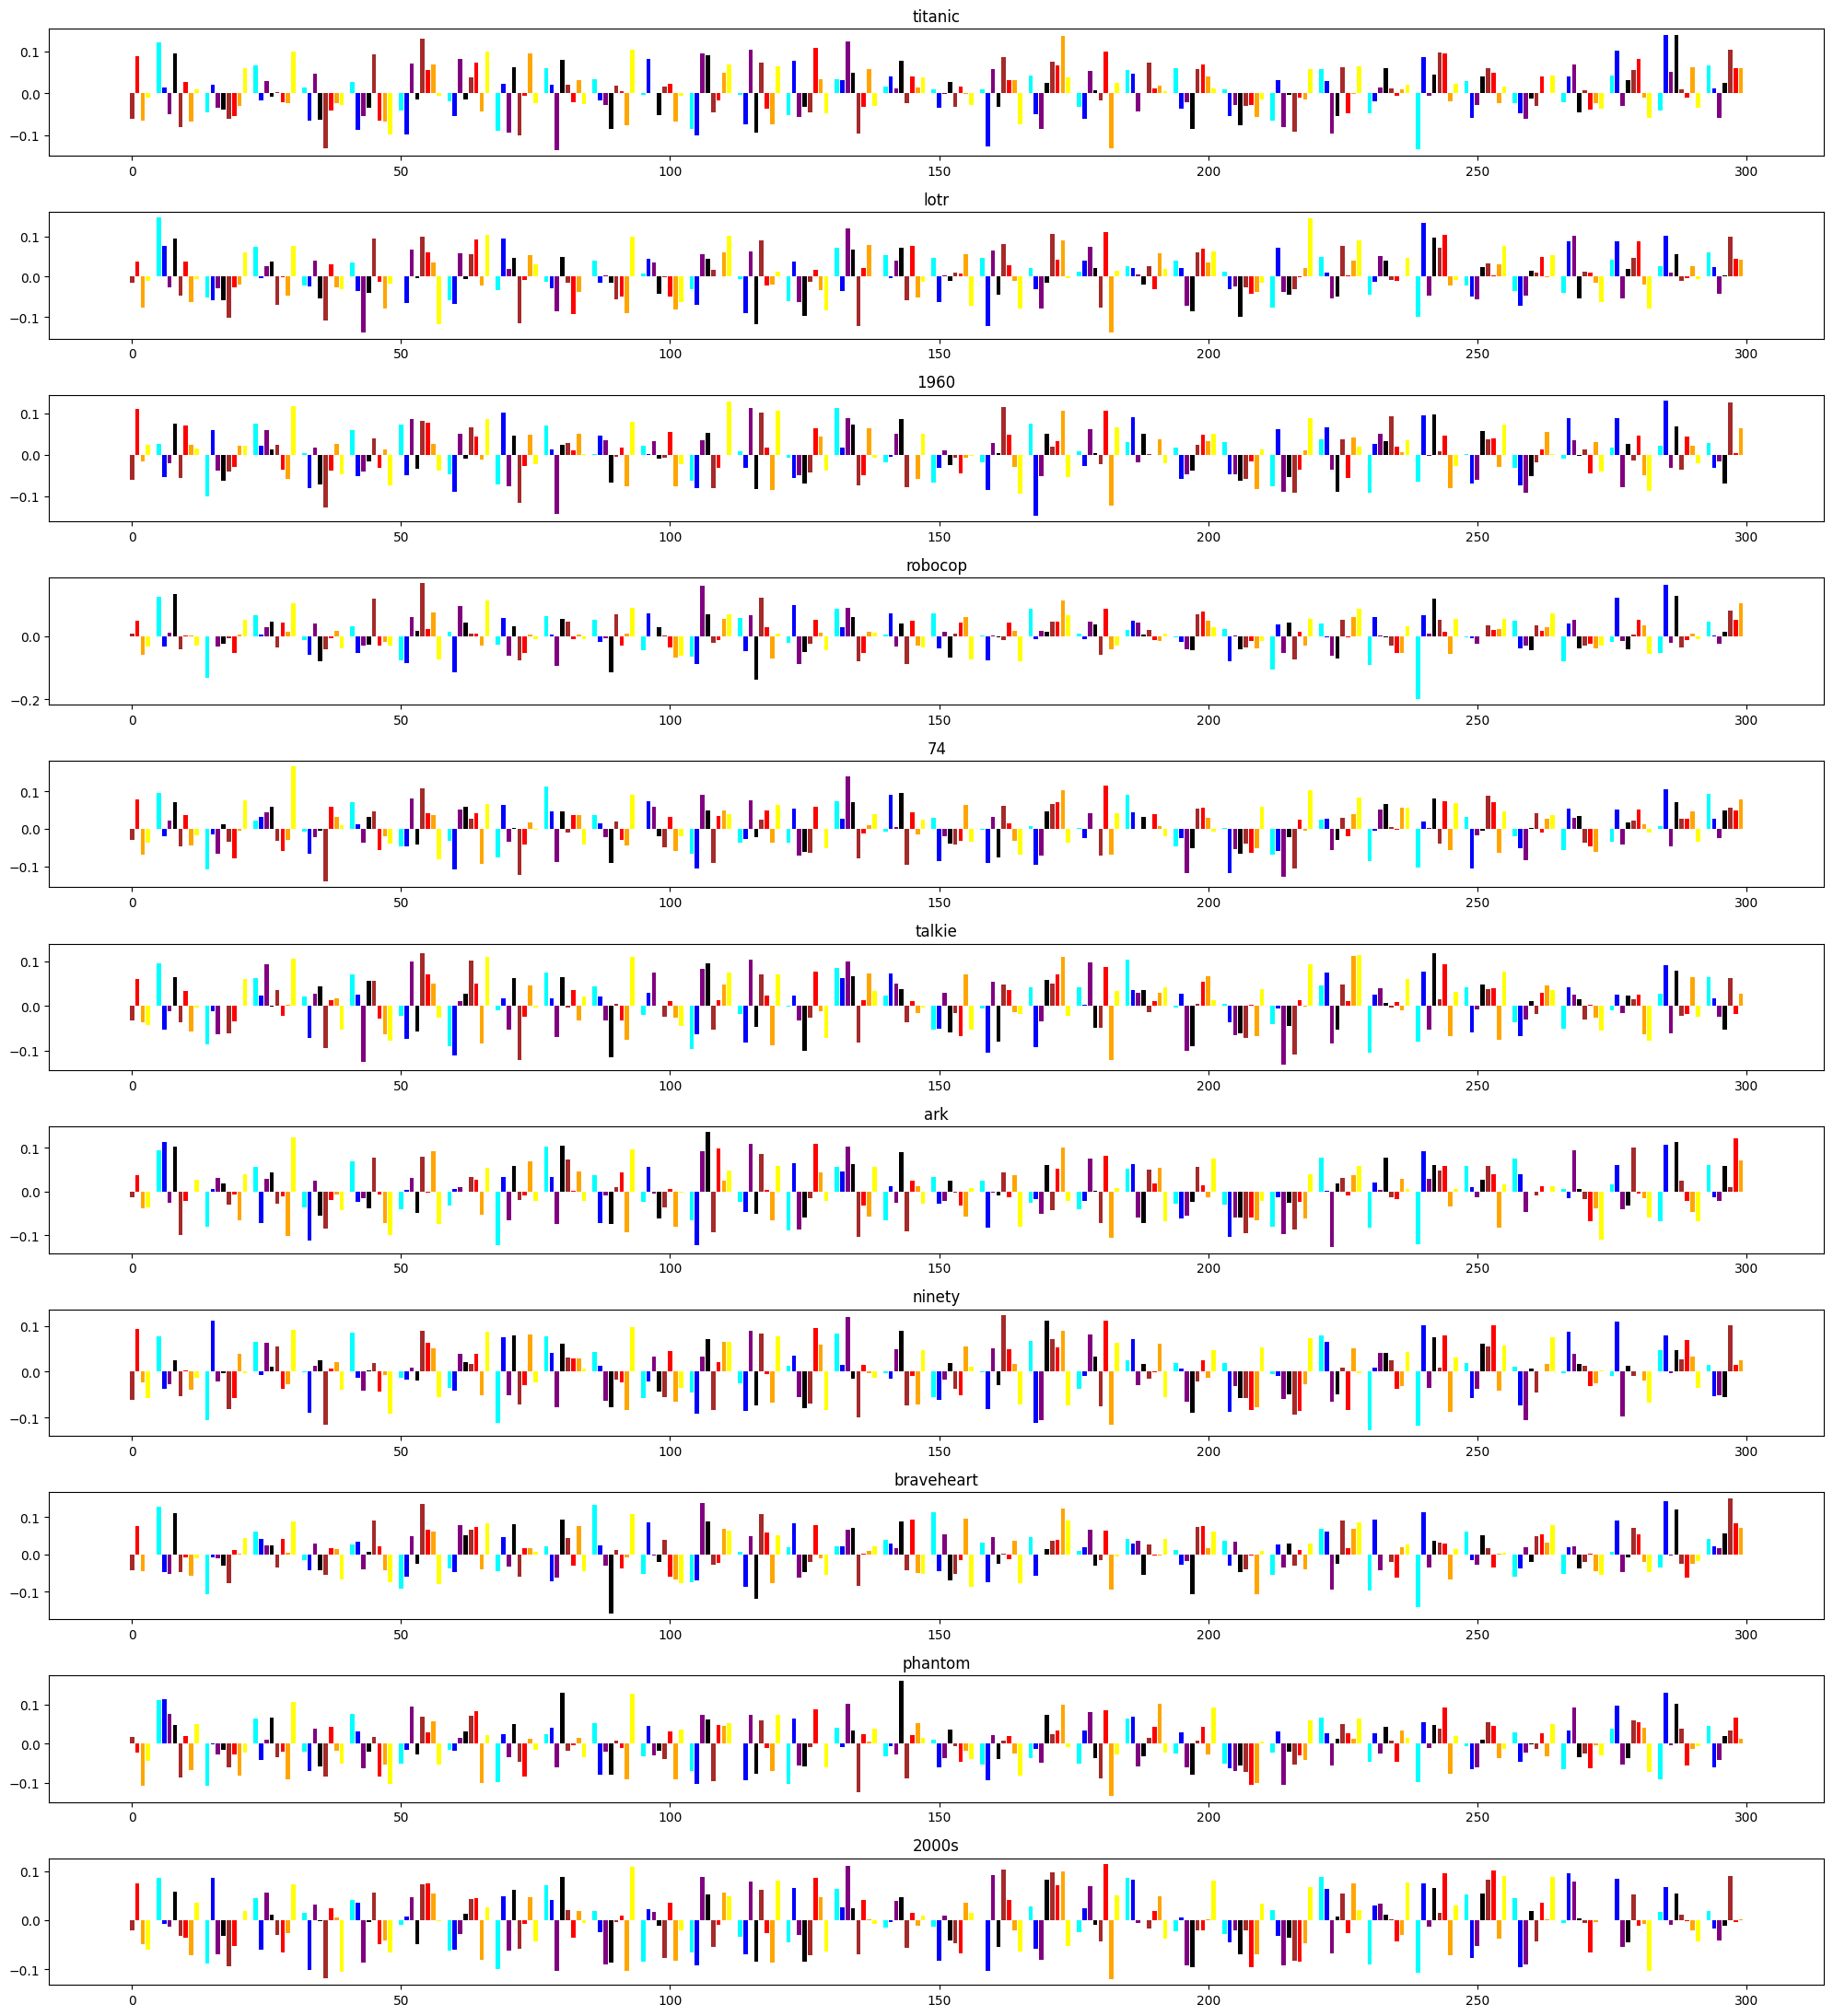

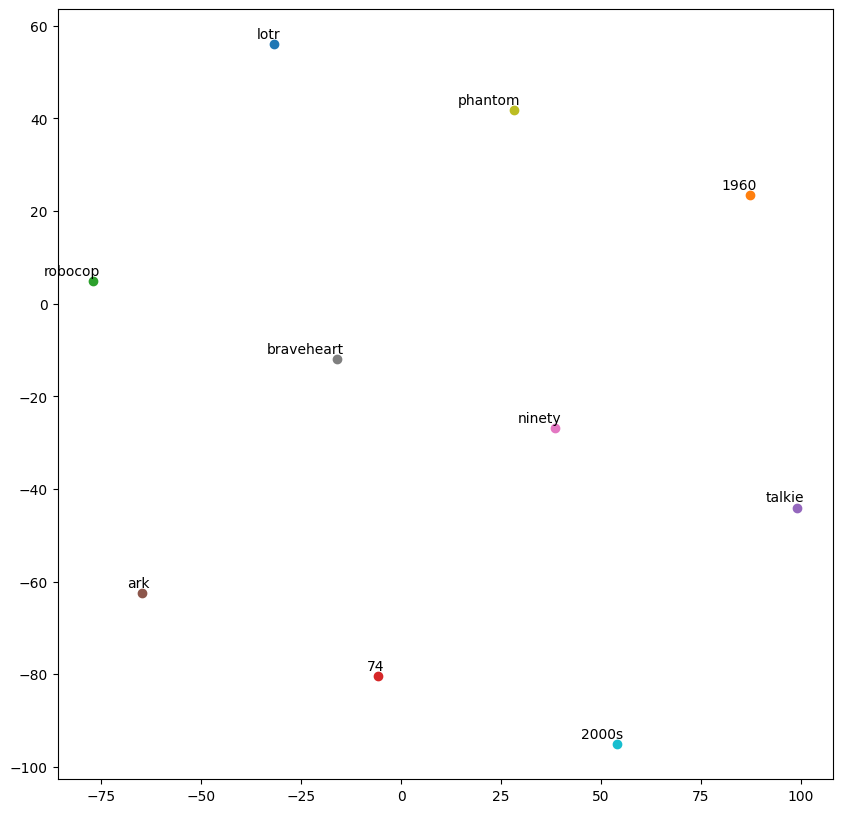

In [10]:
words = ['boat', 'review', 'her', 'great', 'smart', 'titanic']
for word in words:
    plot_top10_words(word , cbow_own)


10it [00:00, 2146.96it/s]


Word:  beautifully
Top 10 similar words:  ['brilliantly', 'wonderfully', 'superbly', 'masterfully', 'expertly', 'nicely', 'finely', 'cleverly', 'gorgeously', 'lovingly']


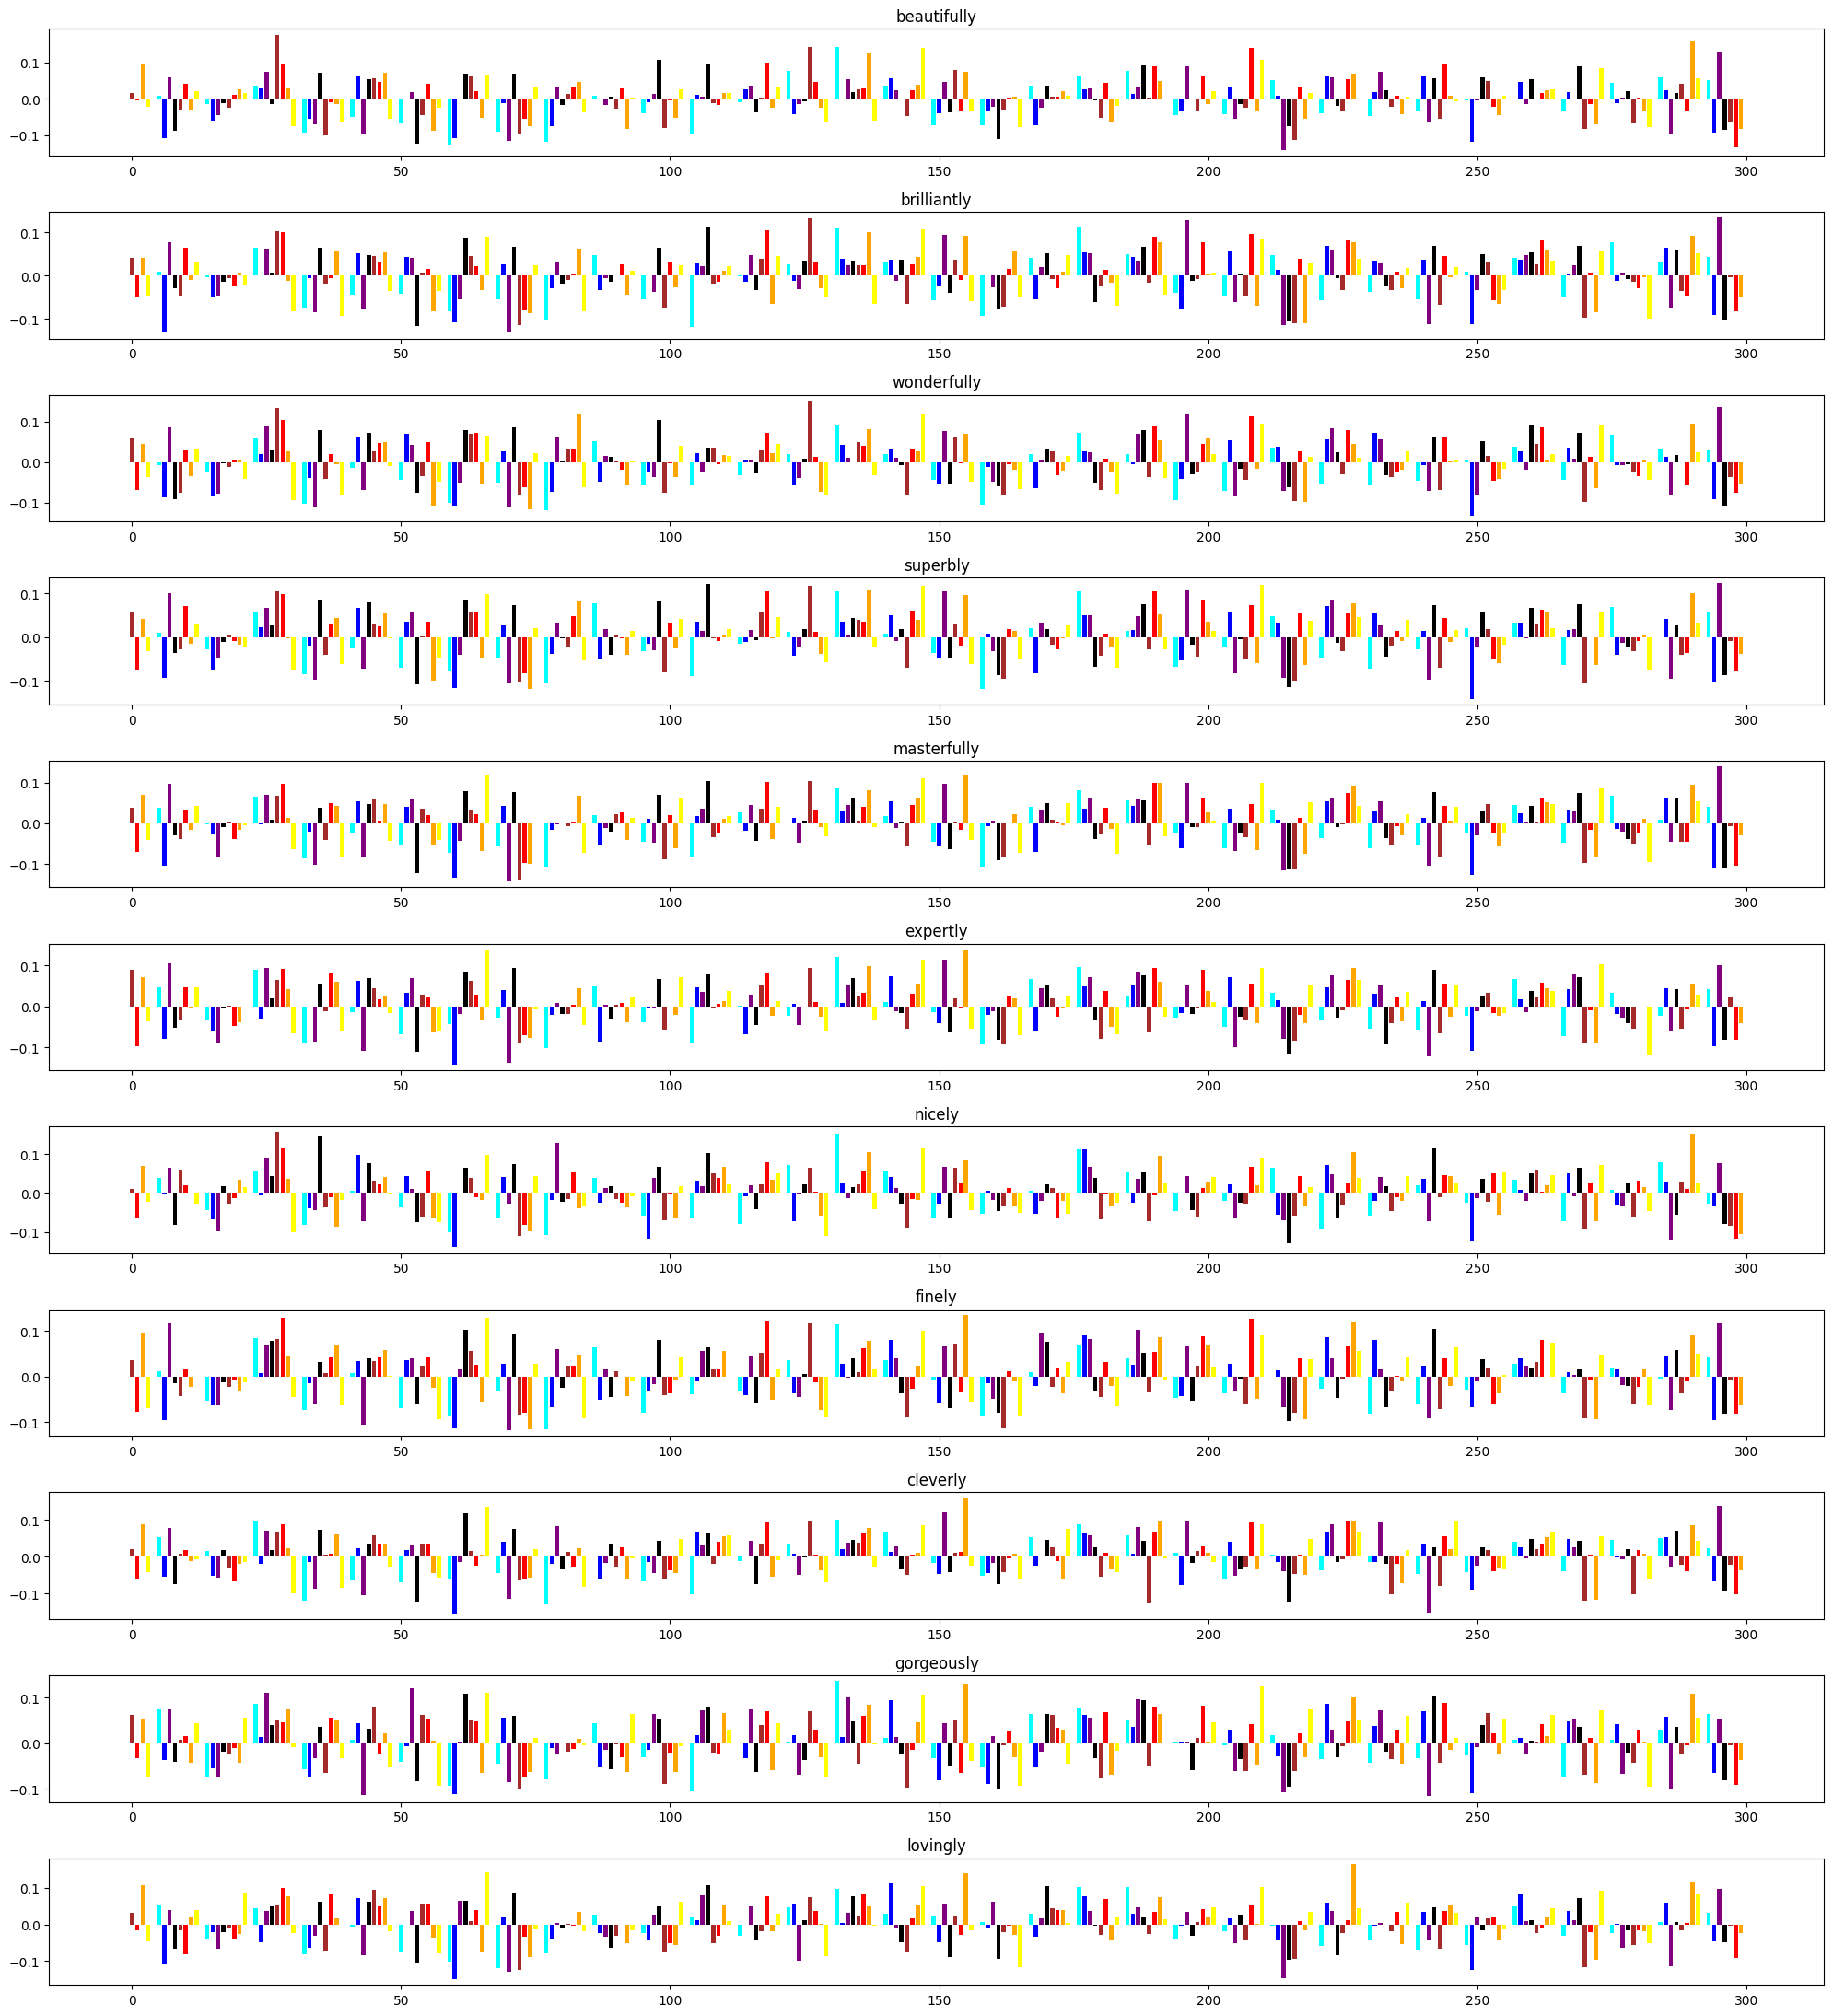

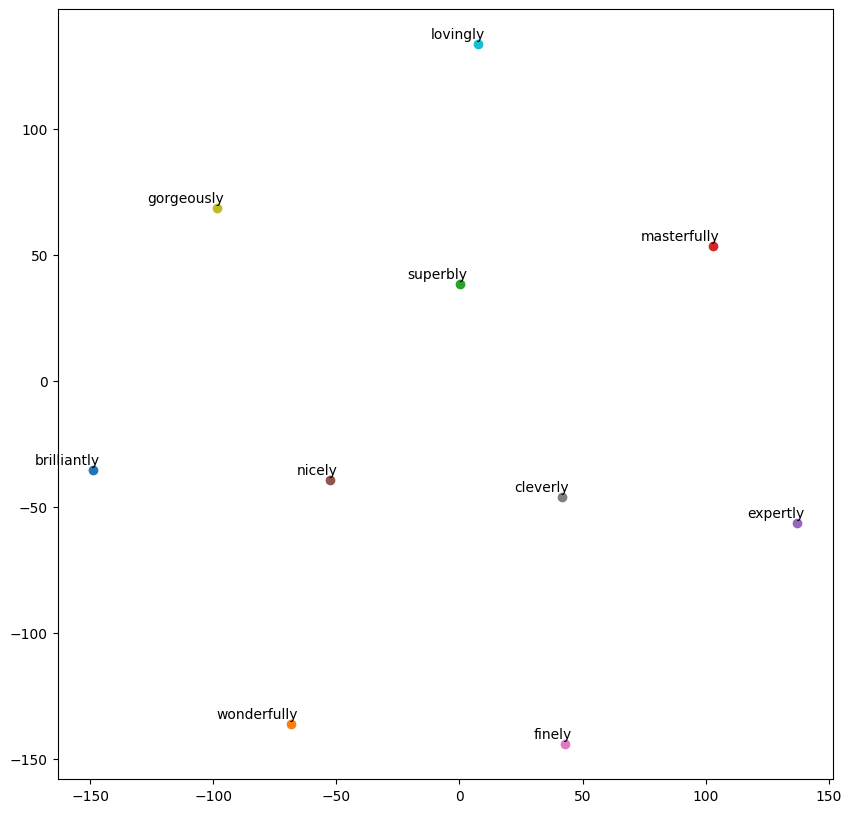

In [11]:
plot_top10_words('beautifully',cbow_own)

10it [00:00, 2580.79it/s]


Word:  behave
Top 10 similar words:  ['react', 'wander', 'operate', 'breathe', 'brainwash', 'overact', 'emote', 'heal', 'strive', 'suppress']


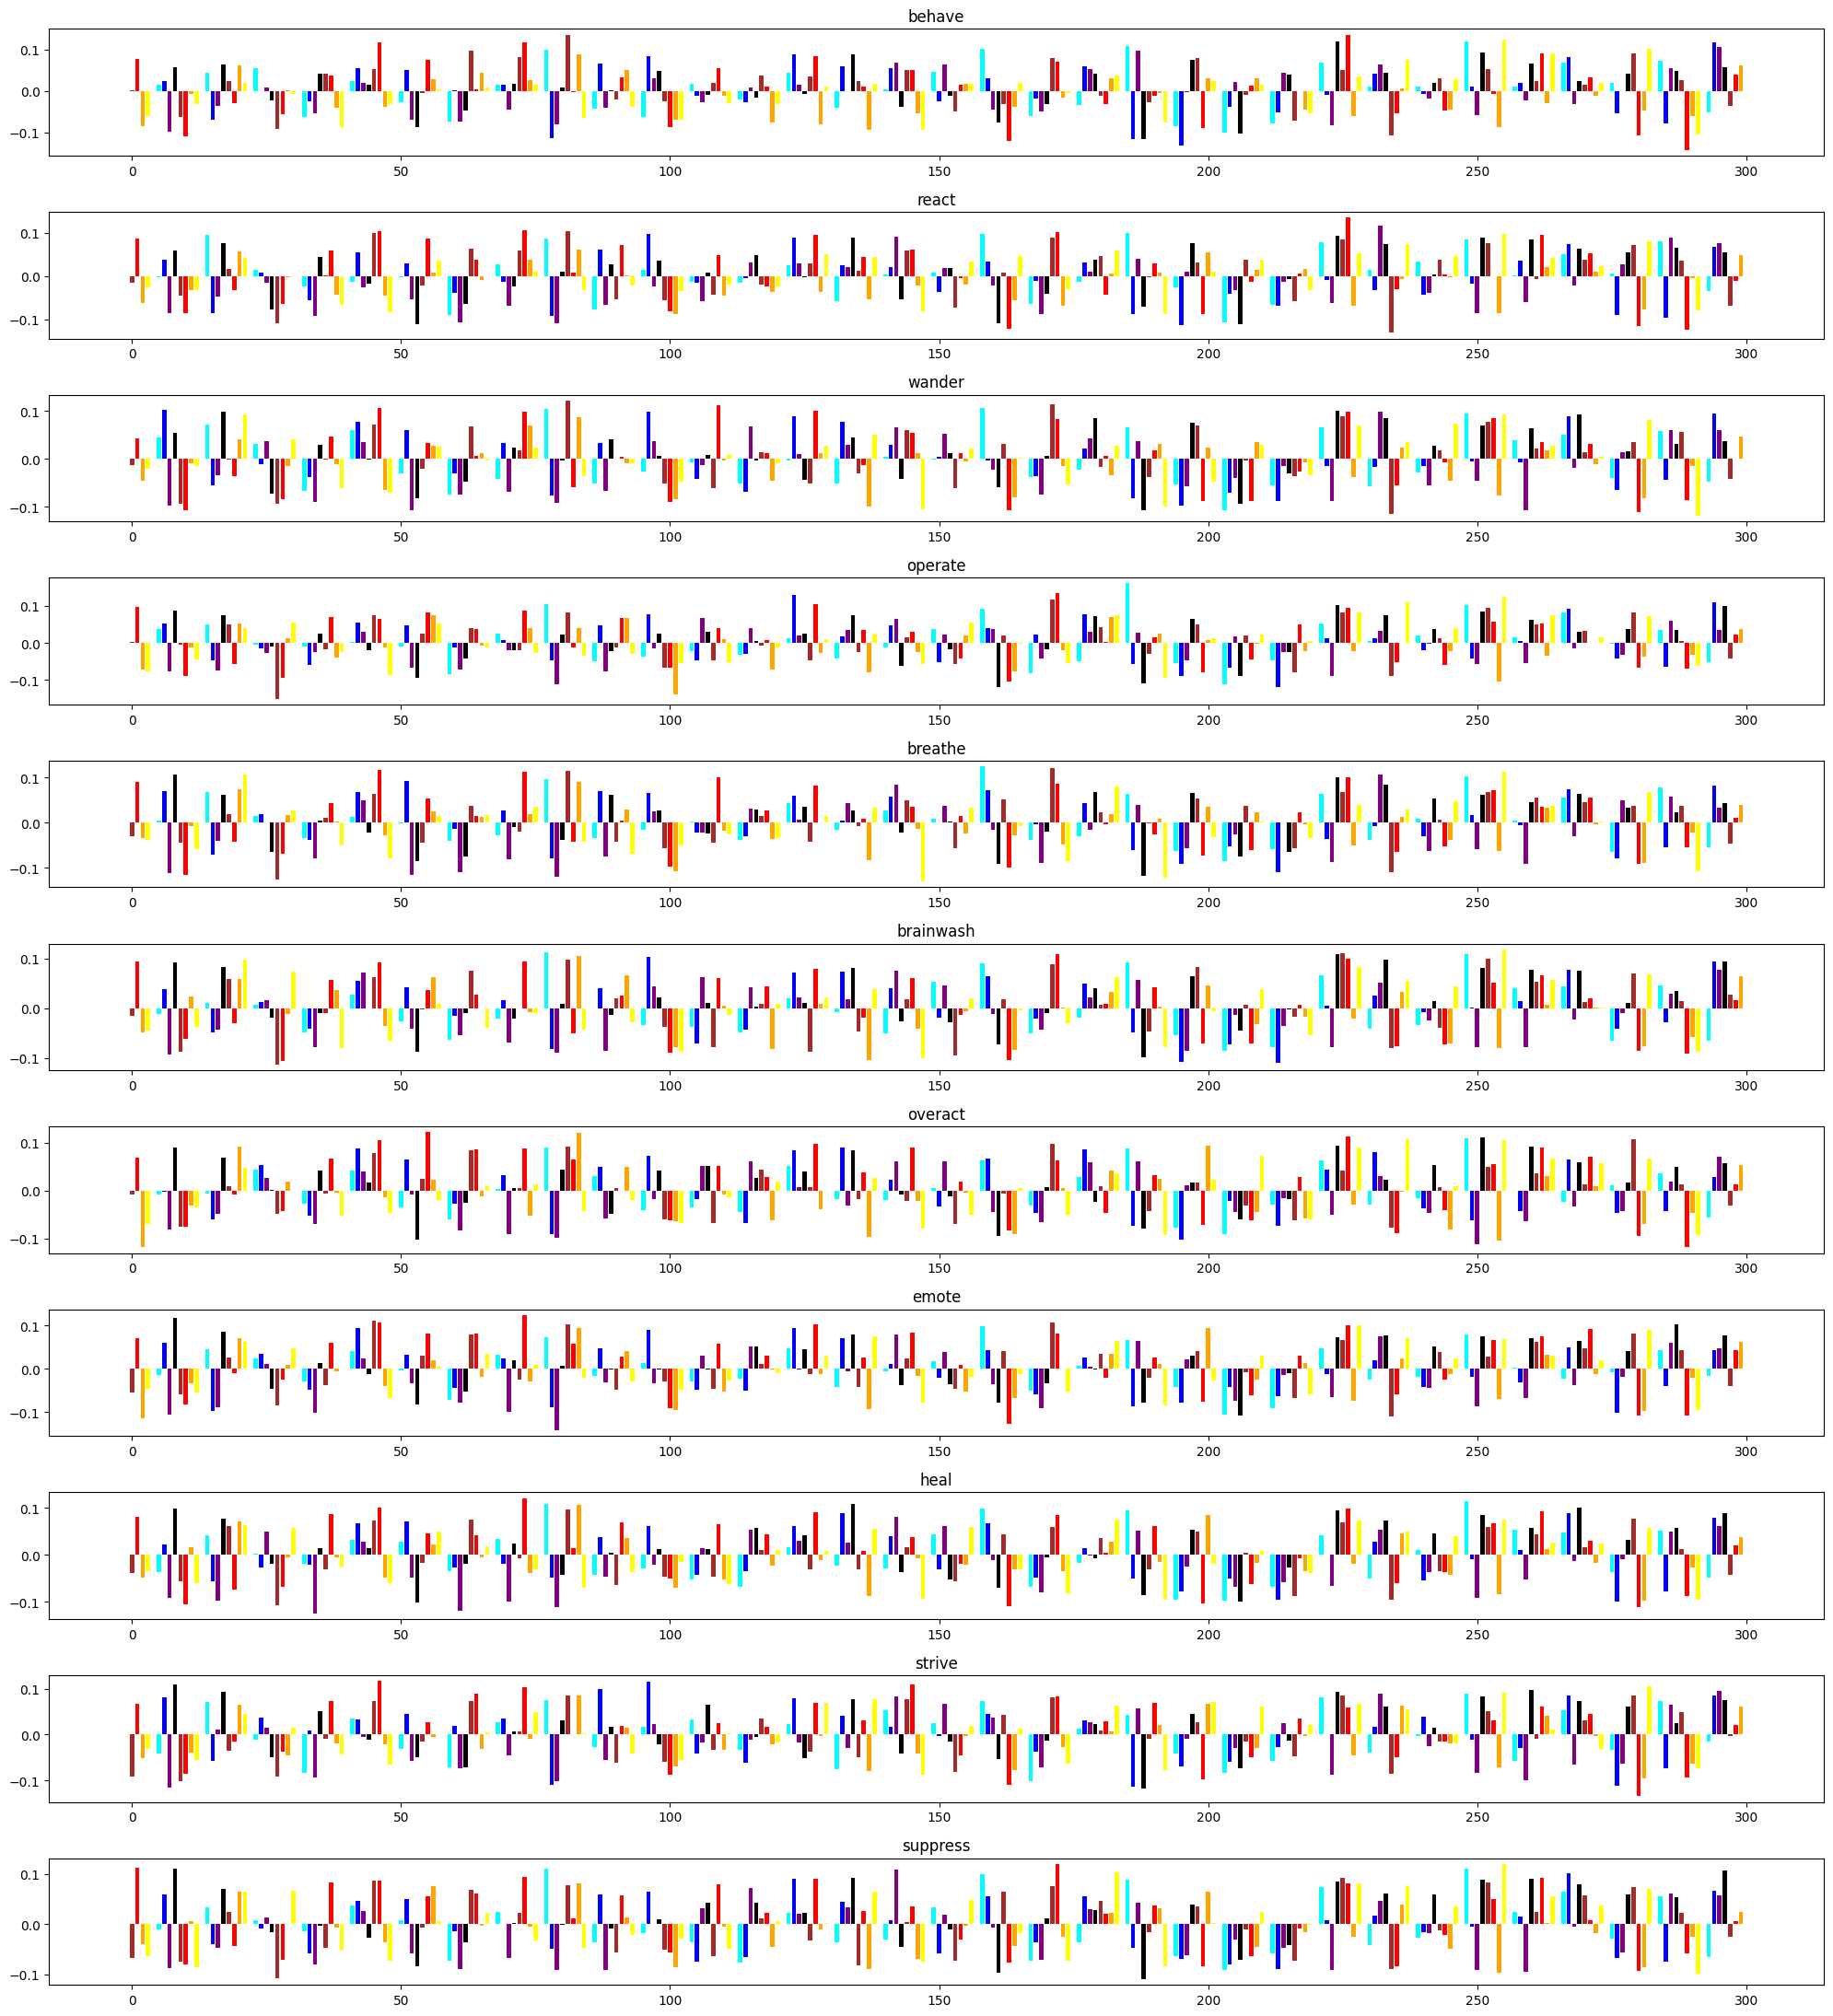

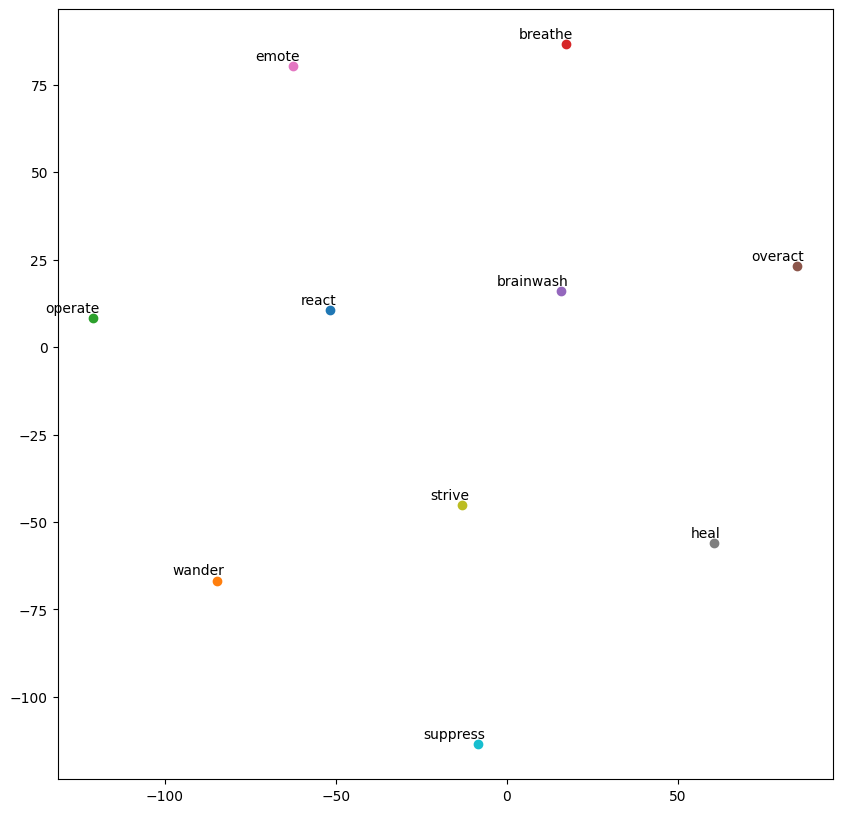

In [23]:
plot_top10_words('behave', cbow_own)
